In [1]:
import numpy as np
import sklearn.datasets
import umap
import umap.plot
import umap.utils as utils
import umap.aligned_umap
import matplotlib.pyplot as plt
import pandas as pd
import os

c:\Users\Gsima\OneDrive - Marquette University\AI Projects - Documents\General\Projects\Moonshot\Rat Gambling Task\AlignedUMAP\sklearn_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Gsima\OneDrive - Marquette University\AI Projects - Documents\General\Projects\Moonshot\Rat Gambling Task\AlignedUMAP\sklearn_env\Lib\site-packages\numba\np\ufunc\dufunc.py:344: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
c:\Users\Gsima\OneDrive - Marquette University\AI Projects - Documents\General\Projects\Moonshot\Rat Gambling Task\AlignedUMAP\sklearn_env\Lib\site-packages\numba\np\ufunc\dufunc.py:344: NumbaWarni

In [ ]:
new_dir = 'enter/your/directory/here'
if os.path.exists(new_dir):
    os.chdir(new_dir)
else:
    print(f"The directory {new_dir} does not exist.")

In [2]:
all_m2 = pd.read_csv('all_m2.csv')
all_pat = pd.read_csv('all_pat.csv')


In [3]:
# Concatenate the dataframes
combined_df = pd.concat([all_m2, all_pat], axis=0)

combined_df = combined_df.sort_values(by=['Subject_Encoded', 'Session', 'Choice_Num'])

# Display the first few rows of the combined dataframe
combined_df.head()

Subject  Genotype  Session  Choice_Num  TrialOutcome_Win  \
0  M2-4247         1        1           1                 0   
1  M2-4247         1        1           2                 1   
2  M2-4247         1        1           3                 1   
3  M2-4247         1        1           4                 1   
4  M2-4247         1        1           5                 1   

   TrialOutcome_Loss  TrialOutcome_Premature  TrialOutcome_Omission  \
0                  0                       1                      0   
1                  0                       0                      0   
2                  0                       0                      0   
3                  0                       0                      0   
4                  0                       0                      0   

   Trial_Length  Pellets_Accumulated  ...  P3_Position_Outside  \
0        11.594                    0  ...                 True   
1        28.442                    3  ...                 True   
2        89.320                    4  ...                 True   
3        48.210                    6  ...                 True   
4        11.915                   10  ...                 True   

   P4_Position_Outside  Risky_Choice_Percentage  Stimulus_1  Stimulus_2  \
0                False                 0.000000       False        True   
1                False                 1.000000       False       False   
2                False                 0.500000        True       False   
3                False                 0.333333       False        True   
4                False                 0.500000       False       False   

   Stimulus_3  Stimulus_4  Stimulus_Inactive  Stimulus_Omission  \
0       False       False              False              False   
1        True       False              False              False   
2       False       False              False              False   
3       False       False              False              False   
4       False        True              False              False   

   Subject_Encoded  
0                0  
1                0  
2                0  
3                0  
4                0  

[5 rows x 35 columns]

In [4]:
from sklearn.preprocessing import StandardScaler

###############################################################################
# 1) Define the 4 features of interest
###############################################################################
FEATURES = [
    'ExecFunctionRatio',
    'ChoicePunishDrive',
    'ChoiceRwdDrive',
    'Risky_Choice_Percentage'
]

###############################################################################
# 2) Aggregate data by subject and session, compute mean/median/min/max/std
###############################################################################
def aggregate_subject_stats(df, features=None, subject_col='Subject', genotype_col='Genotype', session_col='Session'):
    """
    Calculate aggregated statistics for each subject across specified features and standardize the mean values.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The input dataframe containing the data
    features : list, optional
        List of feature columns to aggregate. If None, uses default features.
    subject_col : str
        Column name for subject identifier (default: 'Subject')
    genotype_col : str
        Column name for genotype (default: 'Genotype')
    session_col : str
        Column name for session (default: 'Session')
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame containing aggregated statistics for each subject and session, with standardized mean values
    """
    # Default features if none provided
    if features is None:
        features = [
            'ExecFunctionRatio',
            'ChoicePunishDrive',
            'ChoiceRwdDrive',
            'Risky_Choice_Percentage'
        ]
    
    # Create a dictionary for the aggregation
    agg_dict = {}
    for feature in features:
        agg_dict[f'{feature}_mean'] = (feature, 'mean')
        agg_dict[f'{feature}_median'] = (feature, 'median')
        agg_dict[f'{feature}_min'] = (feature, 'min')
        agg_dict[f'{feature}_max'] = (feature, 'max')
        agg_dict[f'{feature}_std'] = (feature, 'std')
    
    # Group by subject and session, calculate statistics
    aggregated_stats = df.groupby([subject_col, genotype_col, session_col]).agg(**agg_dict) # ** dictionary unpacking
    
    # Reset index to make subject and session regular columns
    aggregated_stats = aggregated_stats.reset_index()
    
    # Standardize the mean values
    scaler = StandardScaler()
    mean_columns = [f'{feature}_mean' for feature in features]
    
    # Fit and transform the mean values
    standardized_means = scaler.fit_transform(aggregated_stats[mean_columns])
    
    # Create new columns for standardized means
    for i, feature in enumerate(features):
        aggregated_stats[f'{feature}_mean_standardized'] = standardized_means[:, i]
    
    return aggregated_stats
   


In [5]:
df = aggregate_subject_stats(
         combined_df,
         subject_col='Subject',
         genotype_col='Genotype',
         session_col='Session'
    )

In [6]:
df.shape

(1020, 27)

In [8]:
df.to_csv('dataframe_AlignUMAP.csv', index = False)

In [7]:
df.head(16)

Subject  Genotype  Session  ExecFunctionRatio_mean  \
0   M2-4247         1        1                0.641391   
1   M2-4247         1        2                0.526565   
2   M2-4247         1        3                0.535885   
3   M2-4247         1        4                0.551637   
4   M2-4247         1        5                0.506041   
5   M2-4247         1        6                0.475938   
6   M2-4247         1        7                0.544875   
7   M2-4247         1        8                0.606120   
8   M2-4247         1        9                0.593065   
9   M2-4247         1       10                0.685808   
10  M2-4247         1       11                0.423903   
11  M2-4247         1       12                0.568830   
12  M2-4247         1       13                0.697924   
13  M2-4247         1       14                0.628912   
14  M2-4247         1       15                0.641563   
15  M2-4248         1        1                0.572354   

    ExecFunctionRatio_median  ExecFunctionRatio_min  ExecFunctionRatio_max  \
0                   0.711073               0.000000                    1.0   
1                   0.552540               0.000000                    1.0   
2                   0.662405               0.000000                    1.0   
3                   0.500020               0.000008                    1.0   
4                   0.499297               0.000000                    1.0   
5                   0.549043               0.000000                    1.0   
6                   0.570798               0.000000                    1.0   
7                   0.590165               0.000000                    1.0   
8                   0.536769               0.000000                    1.0   
9                   0.794359               0.000000                    1.0   
10                  0.396371               0.000000                    1.0   
11                  0.534632               0.000000                    1.0   
12                  1.000000               0.000000                    1.0   
13                  0.655264               0.000000                    1.0   
14                  0.749112               0.000000                    1.0   
15                  0.711073               0.000000                    1.0   

    ExecFunctionRatio_std  ChoicePunishDrive_mean  ChoicePunishDrive_median  \
0                0.341206                0.749064                  0.904821   
1                0.359841                0.727861                  0.938061   
2                0.390303                0.730806                  0.934720   
3                0.356790                0.733871                  0.900276   
4                0.371081                0.667840                  0.857594   
5                0.301200                0.690705                  0.812845   
6                0.335704                0.760329                  1.000000   
7                0.326847                0.605736                  0.783834   
8                0.373945                0.593913                  0.842564   
9                0.346003                0.651567                  0.800589   
10               0.390972                0.534016                  0.462567   
11               0.385483                0.525042                  0.471730   
12               0.394593                0.681393                  0.842564   
13               0.378746                0.574193                  0.728094   
14               0.382838                0.619308                  0.838179   
15               0.415365                0.641958                  0.750691   

    ...  ChoiceRwdDrive_std  Risky_Choice_Percentage_mean  \
0   ...            0.342777                      0.336943   
1   ...            0.346431                      0.330640   
2   ...            0.354430                      0.175209   
3   ...            0.344789                      0.145370   
4   ...            0.369833              

Initial AlignedUMAP Embedding - Using StandardScaler of Mean

Session 1: 76 subjects
Session 2: 76 subjects
Session 3: 76 subjects
Session 4: 76 subjects
Session 5: 76 subjects
Session 6: 76 subjects
Session 7: 76 subjects
Session 8: 76 subjects
Session 9: 76 subjects
Session 10: 76 subjects
Session 11: 76 subjects
Session 12: 76 subjects
Session 13: 36 subjects
Session 14: 36 subjects
Session 15: 36 subjects
Session 1 to 2: 76 relations
Session 2 to 3: 76 relations
Session 3 to 4: 76 relations
Session 4 to 5: 76 relations
Session 5 to 6: 76 relations
Session 6 to 7: 76 relations
Session 7 to 8: 76 relations
Session 8 to 9: 76 relations
Session 9 to 10: 76 relations
Session 10 to 11: 76 relations
Session 11 to 12: 76 relations
Session 12 to 13: 36 relations
Session 13 to 14: 36 relations
Session 14 to 15: 36 relations


c:\Users\Gsima\OneDrive - Marquette University\AI Projects - Documents\General\Projects\Moonshot\Rat Gambling Task\AlignedUMAP\sklearn_env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Gsima\OneDrive - Marquette University\AI Projects - Documents\General\Projects\Moonshot\Rat Gambling Task\AlignedUMAP\sklearn_env\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\Gsima\OneDrive - Marquette University\AI Projects - Documents\General\Projects\Moonshot\Rat Gambling Task\AlignedUMAP\sklearn_env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Gsima\OneDrive - Marquette University\AI Projects - Documents\General\Projects\Moons

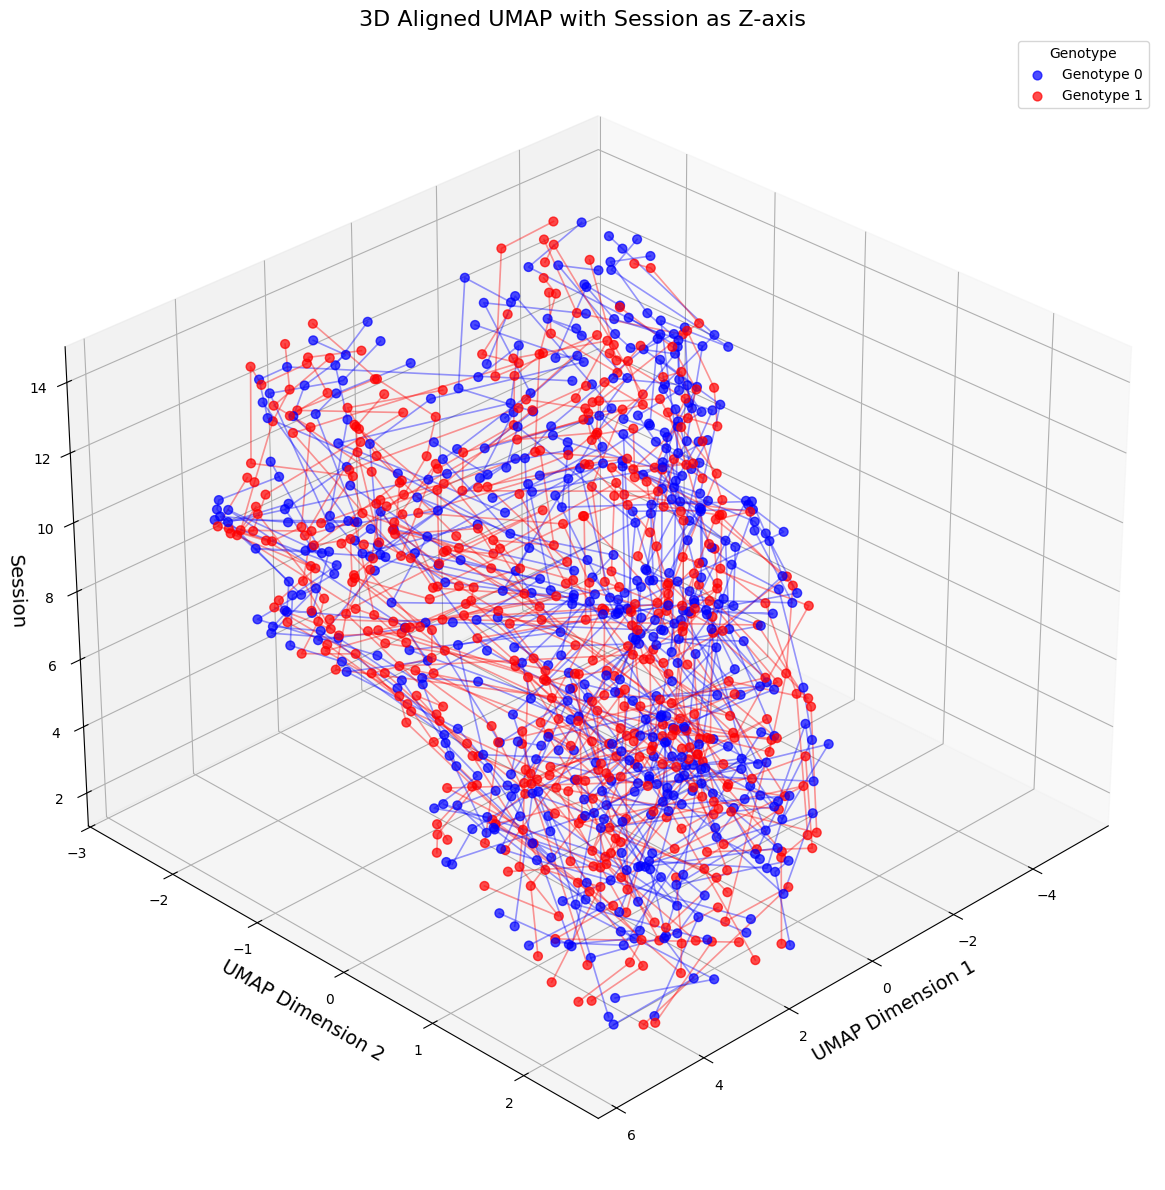

In [8]:
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from umap.aligned_umap import AlignedUMAP
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
from sklearn.cluster import KMeans
import seaborn as sns

# Features we want to use for embedding
features = [
    'ExecFunctionRatio_mean_standardized',
    'ChoicePunishDrive_mean_standardized',
    'ChoiceRwdDrive_mean_standardized',
    'Risky_Choice_Percentage_mean_standardized'
]

# Prepare data for AlignedUMAP
sessions = sorted(df['Session'].unique())
session_data = []
session_subjects = []
session_genotypes = []

for session in sessions:
    # Get data for this session
    session_df = df[df['Session'] == session].sort_values('Subject')
    
    # Store the session data and metadata
    session_data.append(session_df[features].values)
    session_subjects.append(session_df['Subject'].values)
    session_genotypes.append(session_df['Genotype'].values)
    
    print(f"Session {session}: {len(session_df)} subjects")

# Create proper relations between consecutive sessions
relations = []
for i in range(len(sessions) - 1):
    # Create mapping from subject to index for both sessions
    subj_to_idx_i = {subj: idx for idx, subj in enumerate(session_subjects[i])}
    subj_to_idx_j = {subj: idx for idx, subj in enumerate(session_subjects[i+1])}
    
    # Find common subjects and build relation dictionary
    common_subjects = set(subj_to_idx_i.keys()) & set(subj_to_idx_j.keys())
    relation_dict = {subj_to_idx_i[subj]: subj_to_idx_j[subj] for subj in common_subjects}
    
    print(f"Session {sessions[i]} to {sessions[i+1]}: {len(relation_dict)} relations")
    relations.append(relation_dict)

# Configure and run AlignedUMAP
reducer = AlignedUMAP(
    n_components=2,  # We'll use 2D embeddings and add session as z
    n_neighbors=15,   
    min_dist=0.1,
    metric='euclidean',
    random_state=42
)

# Fit and transform the data with relations
embeddings = reducer.fit_transform(session_data, relations=relations)

# Create a mapping of (subject, session) to embedding index
subject_to_embedding = {}
for session_idx, (session, subject_list) in enumerate(zip(sessions, session_subjects)):
    for subject_idx, subject in enumerate(subject_list):
        subject_to_embedding[(subject, session)] = (session_idx, subject_idx)

# Create 3D visualization with session as z-axis
fig = plt.figure(figsize=(15, 12))
ax = fig.add_subplot(111, projection='3d')

# Create distinct colors for genotypes
genotype_colors = {0: 'blue', 1: 'red'}

# Plot each session's embedding on its respective z-level
for session_idx, session in enumerate(sessions):
    for genotype in [0, 1]:
        mask = session_genotypes[session_idx] == genotype
        if np.any(mask):
            ax.scatter(
                embeddings[session_idx][mask, 0], 
                embeddings[session_idx][mask, 1], 
                # Use actual session number (1-15) for z-axis
                np.ones(np.sum(mask)) * session,
                color=genotype_colors[genotype],
                s=40,
                alpha=0.7,
                label=f"Genotype {genotype}" if session_idx == 0 else None
            )

# Plot subject trajectories
subjects = df['Subject'].unique()


for subject in subjects:
    # Get sessions where this subject appears
    subject_sessions = sorted(df[df['Subject'] == subject]['Session'].unique())
    if len(subject_sessions) < 2:
        continue
        
    genotype = df[df['Subject'] == subject]['Genotype'].iloc[0]
    coords = []
    
    for session in subject_sessions:
        if (subject, session) in subject_to_embedding:
            session_idx, subject_idx = subject_to_embedding[(subject, session)]
            coords.append((
                embeddings[session_idx][subject_idx, 0],
                embeddings[session_idx][subject_idx, 1],
                session  # Use actual session number for z
            ))
    
    if len(coords) >= 2:
        coords = np.array(coords)
        
        ax.plot(coords[:, 0], coords[:, 1], coords[:, 2], 
                color=genotype_colors[genotype], alpha=0.4, linewidth=1.2)


# Add labels and customize plot
ax.set_title('3D Aligned UMAP with Session as Z-axis', fontsize=16)
ax.set_xlabel('UMAP Dimension 1', fontsize=14)
ax.set_ylabel('UMAP Dimension 2', fontsize=14)
ax.set_zlabel('Session', fontsize=14)
ax.set_zlim(1, 15)
ax.legend(title="Genotype")
ax.view_init(elev=30, azim=45)

plt.tight_layout()
plt.show()


Genotype AlignedUMAP Embedding with Individual Feature Trajectories w Individual Animal values exported as .csv

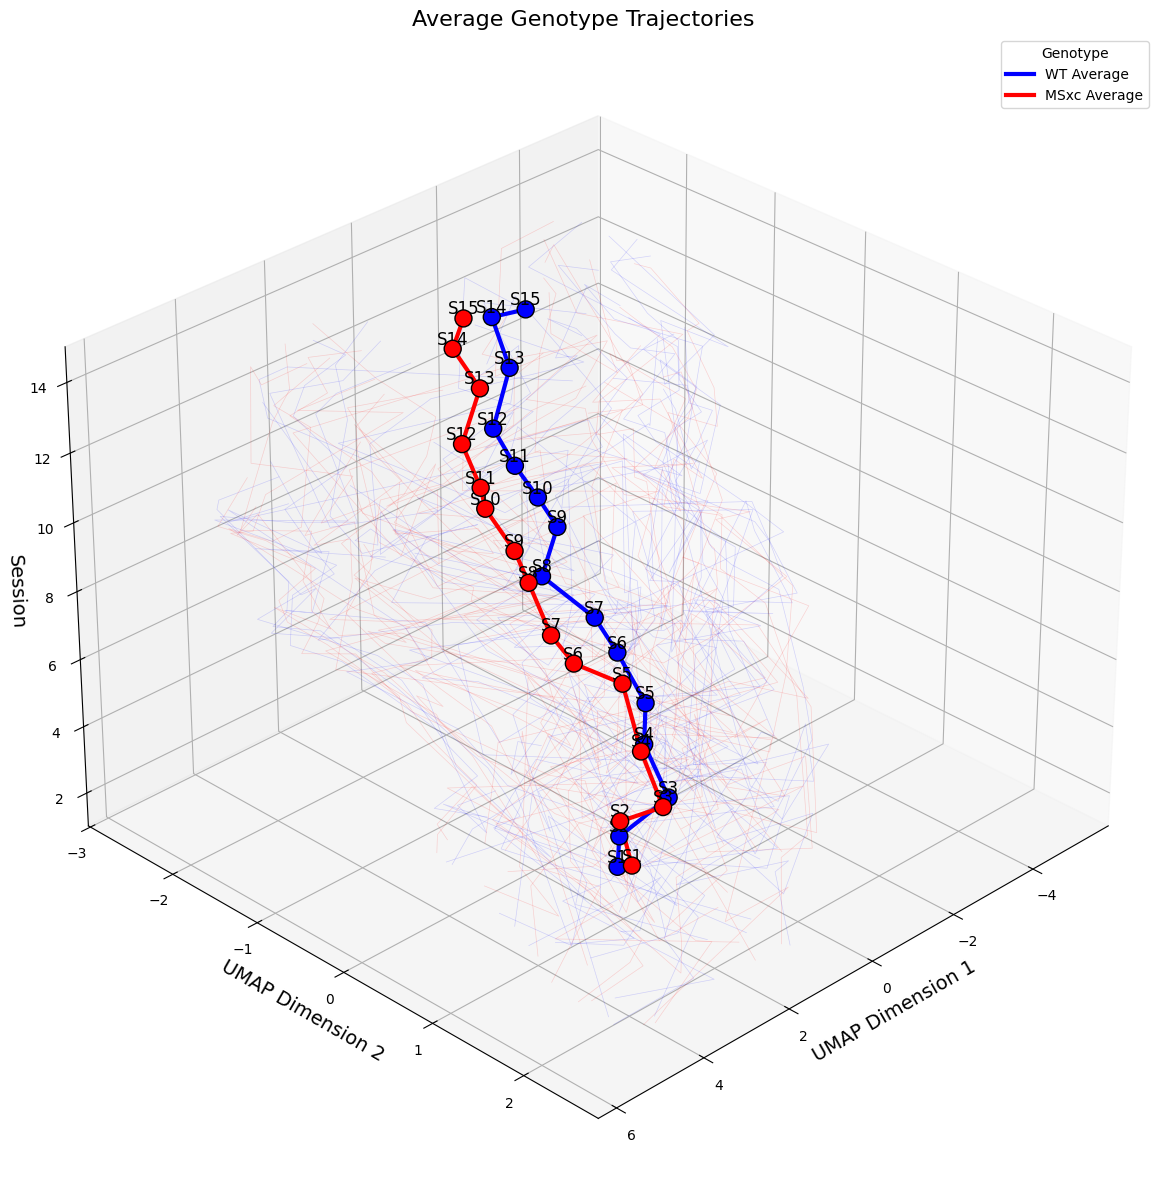

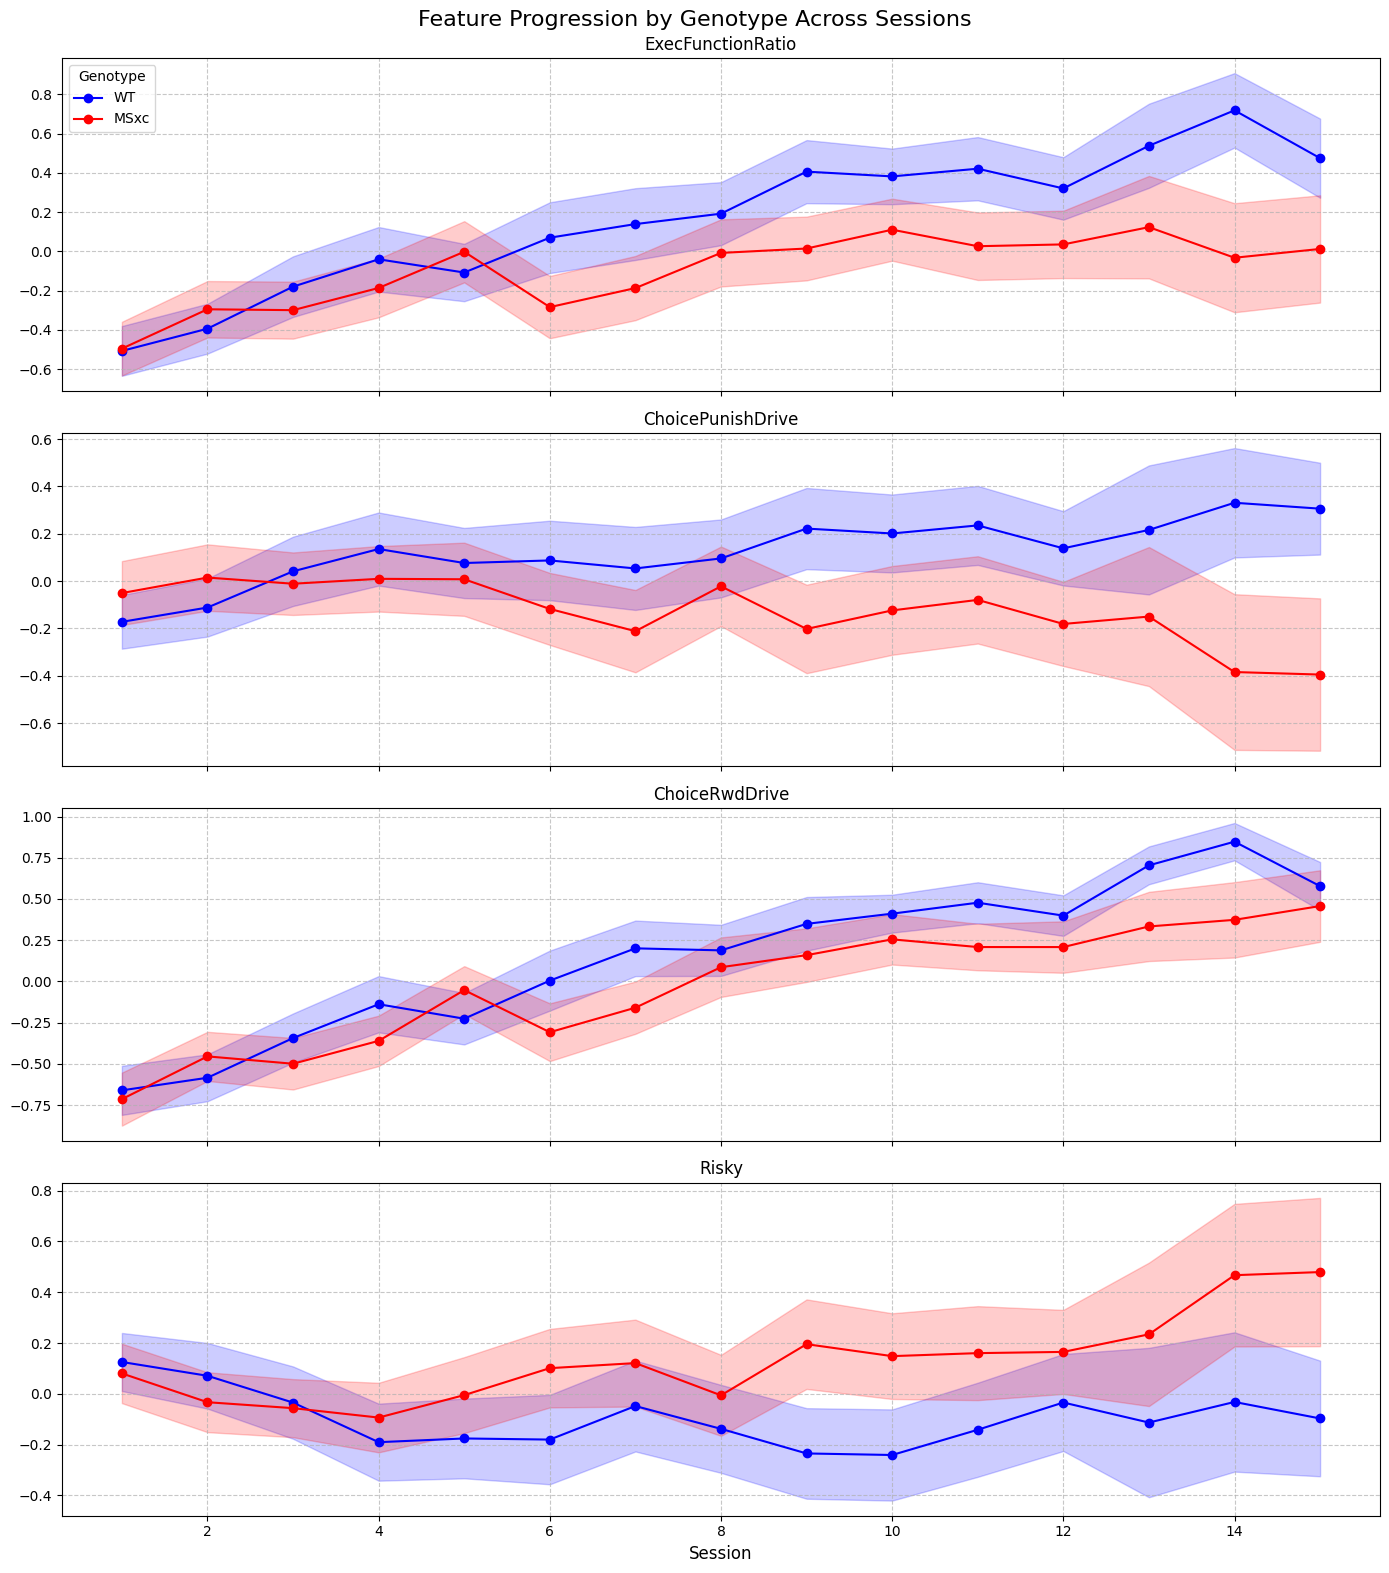

Individual animal data exported to individual_animal_trajectories.csv


In [12]:
# Calculate and visualize average trajectories by genotype
genotype_avg_trajectories = {}
genotype_labels = {0: 'WT', 1: 'MSxc'}

for genotype in [0, 1]:
    # Store average embedding coordinates for each session
    avg_coords_by_session = []
    
    for session_idx, session in enumerate(sessions):
        # Get subjects of this genotype in this session
        session_mask = session_genotypes[session_idx] == genotype
        if np.any(session_mask):
            # Average coordinates for this session/genotype
            avg_coords = np.mean(embeddings[session_idx][session_mask], axis=0)
            avg_coords_by_session.append((avg_coords[0], avg_coords[1], session))
    
    genotype_avg_trajectories[genotype] = np.array(avg_coords_by_session)

# Create figure for average genotype trajectories
fig = plt.figure(figsize=(15, 12))
ax = fig.add_subplot(111, projection='3d')

# Plot individual trajectories with low alpha for context
for subject in subjects:
    subject_sessions = sorted(df[df['Subject'] == subject]['Session'].unique())
    if len(subject_sessions) < 2:
        continue
    
    genotype = df[df['Subject'] == subject]['Genotype'].iloc[0]
    coords = []
    
    for session in subject_sessions:
        if (subject, session) in subject_to_embedding:
            session_idx, subject_idx = subject_to_embedding[(subject, session)]
            coords.append((
                embeddings[session_idx][subject_idx, 0],
                embeddings[session_idx][subject_idx, 1],
                session
            ))
    
    if len(coords) >= 2:
        coords = np.array(coords)
        ax.plot(coords[:, 0], coords[:, 1], coords[:, 2], 
                color=to_rgba(genotype_colors[genotype], alpha=0.15), 
                linewidth=0.5)

# Plot average trajectories with thicker lines and markers
for genotype, avg_trajectory in genotype_avg_trajectories.items():
    ax.plot(avg_trajectory[:, 0], avg_trajectory[:, 1], avg_trajectory[:, 2], 
            color=genotype_colors[genotype], 
            linewidth=3.0, 
            label=f"{genotype_labels[genotype]} Average")
    
    # Add scatter points at each session
    ax.scatter(avg_trajectory[:, 0], avg_trajectory[:, 1], avg_trajectory[:, 2], 
              color=genotype_colors[genotype], s=150, 
              edgecolors='black', linewidths=1, alpha=1.0)

# Add session labels to average trajectory points
for genotype in [0, 1]:
    avg_traj = genotype_avg_trajectories[genotype]
    for i, session in enumerate(sessions[:len(avg_traj)]):
        ax.text(avg_traj[i, 0], avg_traj[i, 1], avg_traj[i, 2], 
                f"S{session}", fontsize=12, ha='center', va='bottom')

# Customize plot
ax.set_title('Average Genotype Trajectories', fontsize=16)
ax.set_xlabel('UMAP Dimension 1', fontsize=14)
ax.set_ylabel('UMAP Dimension 2', fontsize=14)
ax.set_zlabel('Session', fontsize=14)
ax.set_zlim(1, 15)
ax.legend(title="Genotype")
ax.view_init(elev=30, azim=45)

plt.tight_layout()
plt.show()

# Create side-by-side comparison of feature progression by genotype
fig, axes = plt.subplots(len(features), 1, figsize=(14, 4*len(features)), sharex=True)
for i, feature in enumerate(features):
    # Calculate feature means by session and genotype
    feature_by_session = df.groupby(['Session', 'Genotype'])[feature].agg(['mean', 'sem']).reset_index()
    
    for genotype in [0, 1]:
        data = feature_by_session[feature_by_session['Genotype'] == genotype]
        axes[i].plot(data['Session'], data['mean'], marker='o', 
                     color=genotype_colors[genotype], label=f"{genotype_labels[genotype]}")
        axes[i].fill_between(data['Session'], 
                            data['mean'] - data['sem'], 
                            data['mean'] + data['sem'], 
                            alpha=0.2, color=genotype_colors[genotype])
    
    axes[i].set_title(feature.split('_')[0], fontsize=12)
    axes[i].grid(True, linestyle='--', alpha=0.7)
    if i == 0:
        axes[i].legend(title="Genotype")
    if i == len(features)-1:
        axes[i].set_xlabel('Session', fontsize=12)

plt.suptitle('Feature Progression by Genotype Across Sessions', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()



# Export individual animal data to CSV
individual_data = []

for subject in subjects:
    subject_data = df[df['Subject'] == subject]
    if len(subject_data) > 0:
        # Get subject's genotype
        genotype = subject_data['Genotype'].iloc[0]
        
        # For each session, get the UMAP coordinates and features
        for session in sessions:
            session_data = subject_data[subject_data['Session'] == session]
            
            if (subject, session) in subject_to_embedding:
                session_idx, subject_idx = subject_to_embedding[(subject, session)]
                umap_coords = embeddings[session_idx][subject_idx]
                
                # Create row with subject info, coordinates, and features
                if not session_data.empty:
                    row_data = {
                        'Subject': subject,
                        'Genotype': genotype,
                        'Session': session,
                        'UMAP1': umap_coords[0],
                        'UMAP2': umap_coords[1]
                    }
                    # Add all features
                    for feature in features:
                        if feature in session_data.columns:
                            row_data[feature] = session_data[feature].iloc[0]
                    
                    individual_data.append(row_data)

# Convert to DataFrame and export to CSV
individual_df = pd.DataFrame(individual_data)
output_filename = 'individual_animal_trajectories.csv'
individual_df.to_csv(output_filename, index=False)
print(f"Individual animal data exported to {output_filename}")


Full HTML Dashboard with Genotype, Feature Progression, and Sub-Cluster Trajectories

In [14]:
import plotly.graph_objects as go
import plotly.express as px
import numpy as np
from plotly.subplots import make_subplots

def create_interactive_genotype_trajectories():
    # Calculate average trajectories by genotype
    genotype_avg_trajectories = {}
    
    for genotype in [0, 1]:
        # Store average embedding coordinates for each session
        avg_coords_by_session = []
        
        for session_idx, session in enumerate(sessions):
            # Get subjects of this genotype in this session
            session_mask = session_genotypes[session_idx] == genotype
            if np.any(session_mask):
                # Average coordinates for this session/genotype
                avg_coords = np.mean(embeddings[session_idx][session_mask], axis=0)
                avg_coords_by_session.append((avg_coords[0], avg_coords[1], session))
        
        genotype_avg_trajectories[genotype] = np.array(avg_coords_by_session)

    # Calculate x-axis bounds from all trajectory data
        all_x_coords = []
        for genotype, avg_trajectory in genotype_avg_trajectories.items():
            all_x_coords.extend(avg_trajectory[:, 0])

        # Include individual trajectories for complete bounds calculation
        for subject in subjects:
            subject_sessions = sorted(df[df['Subject'] == subject]['Session'].unique())
            if len(subject_sessions) < 2: continue
            for session in subject_sessions:
                if (subject, session) in subject_to_embedding:
                    session_idx, subject_idx = subject_to_embedding[(subject, session)]
                    all_x_coords.append(embeddings[session_idx][subject_idx, 0])

        # Calculate optimized range
        x_min, x_max = min(all_x_coords), max(all_x_coords)
        x_range = x_max - x_min
        x_center = (x_min + x_max)/2
        reduced_range = x_range * 0.8  # 20% reduction for stretching
        x_min_new = x_center - reduced_range/2
        x_max_new = x_center + reduced_range/2

    # Create figure
    fig = go.Figure()
    
    # Define colors for genotypes with transparency included
    genotype_colors = {0: 'rgba(0, 0, 255, 0.30)', 1: 'rgba(255, 0, 0, 0.30)'}
    genotype_solid_colors = {0: 'blue', 1: 'red'}
    
    # Plot individual trajectories with low alpha for context
    for subject in subjects:
        subject_sessions = sorted(df[df['Subject'] == subject]['Session'].unique())
        if len(subject_sessions) < 2:
            continue
        
        genotype = df[df['Subject'] == subject]['Genotype'].iloc[0]
        coords = []
        
        for session in subject_sessions:
            if (subject, session) in subject_to_embedding:
                session_idx, subject_idx = subject_to_embedding[(subject, session)]
                coords.append((
                    embeddings[session_idx][subject_idx, 0],
                    embeddings[session_idx][subject_idx, 1],
                    session
                ))
        
        if len(coords) >= 2:
            coords = np.array(coords)
            fig.add_trace(
                go.Scatter3d(
                    x=coords[:, 0],
                    y=coords[:, 1],
                    z=coords[:, 2],
                    mode='lines',
                    line=dict(
                        color=genotype_colors[genotype],
                        width=1
                    ),
                    hoverinfo='skip',
                    showlegend=False
                )
            )
    
    # Plot average trajectories with thicker lines
    for genotype, avg_trajectory in genotype_avg_trajectories.items():
        # Add line for average trajectory
        fig.add_trace(
            go.Scatter3d(
                x=avg_trajectory[:, 0],
                y=avg_trajectory[:, 1],
                z=avg_trajectory[:, 2],
                mode='lines',
                line=dict(
                    color=genotype_solid_colors[genotype],
                    width=8
                ),
                name="WT" if genotype == 0 else "MSxc"
            )
        )
        
        # Add markers for each session point
        fig.add_trace(
            go.Scatter3d(
                x=avg_trajectory[:, 0],
                y=avg_trajectory[:, 1],
                z=avg_trajectory[:, 2],
                mode='markers+text',
                marker=dict(
                    size=8,
                    color=genotype_solid_colors[genotype],
                    line=dict(
                        color='black',
                        width=1
                    )
                ),
                text=[f"S{session}" for session in sessions[:len(avg_trajectory)]],
                textposition="top center",
                textfont=dict(size=10),
                showlegend=False,
                hovertemplate="Genotype %{meta}<br>Session: %{z}<br>UMAP1: %{x:.3f}<br>UMAP2: %{y:.3f}",
                meta=[genotype] * len(avg_trajectory)
            )
        )
    
    # Update layout
    fig.update_layout(
        title="Interactive Average Genotype Trajectories",
        scene=dict(
            xaxis_title="UMAP Dimension 1",
            xaxis=dict(range=[x_min_new, x_max_new]),
            yaxis_title="UMAP Dimension 2",
            zaxis_title="Session",
            zaxis=dict(range=[1, 15], dtick=1),
            camera=dict(
                eye=dict(x=1.5, y=1.5, z=1.5)
            )
        ),
        legend=dict(
            title="Genotype",
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=0.01
        ),
        margin=dict(l=0, r=0, b=0, t=50),
        height=800
    )
    
    # Add camera view buttons
    fig.update_layout(
        updatemenus=[
            dict(
                type="buttons",
                buttons=[
                    dict(
                        label="Top View (Session Plane)",
                        method="relayout",
                        args=["scene.camera", dict(
                            eye=dict(x=0, y=0, z=2.5),
                            center=dict(x=0, y=0, z=0)
                        )]
                    ),
                    dict(
                        label="Side View (UMAP1-Session)",
                        method="relayout",
                        args=["scene.camera", dict(
                            eye=dict(x=0, y=2.5, z=0),
                            center=dict(x=0, y=0, z=0)
                        )]
                    ),
                    dict(
                        label="Front View (UMAP2-Session)",
                        method="relayout",
                        args=["scene.camera", dict(
                            eye=dict(x=2.5, y=0, z=0),
                            center=dict(x=0, y=0, z=0)
                        )]
                    ),
                    dict(
                        label="Diagonal View",
                        method="relayout",
                        args=["scene.camera", dict(
                            eye=dict(x=1.5, y=1.5, z=1.5),
                            center=dict(x=0, y=0, z=0)
                        )]
                    )
                ],
                direction="down",
                pad={"r": 10, "t": 10},
                showactive=True,
                x=0.9,
                y=1.1,
                xanchor="right",
                yanchor="top"
            )
        ]
    )
    
    # Add annotations
    fig.add_annotation(
        text="Rotate: Click and drag | Zoom: Scroll | Pan: Right-click and drag",
        xref="paper", yref="paper",
        x=0.5, y=0,
        showarrow=False,
        font=dict(size=12)
    )
    
    # Save as HTML file
    fig.write_html("genotype_average_trajectories.html")
    
    return fig



# Create the interactive visualization
interactive_genotype_fig = create_interactive_genotype_trajectories()

##################################################################################################################
def create_interactive_feature_progression():
    # Create a subplot for each feature
    fig = make_subplots(
        rows=len(features), 
        cols=1,
        subplot_titles=[feature.split('_')[0] for feature in features],
        shared_xaxes=True,
        vertical_spacing=0.05
    )
    
    # Define colors for genotypes with direct RGBA values
    genotype_colors = {
        0: 'rgba(0, 0, 255, 1)',  # Blue
        1: 'rgba(255, 0, 0, 1)'   # Red
    }
    
    # Define transparent versions for fill
    genotype_fill_colors = {
        0: 'rgba(0, 0, 255, 0.2)',  # Blue with transparency
        1: 'rgba(255, 0, 0, 0.2)'   # Red with transparency
    }
    
    # Add traces for each feature and genotype
    for i, feature in enumerate(features):
        # Calculate feature means by session and genotype
        feature_by_session = df.groupby(['Session', 'Genotype'])[feature].agg(['mean', 'sem']).reset_index()
        
        for genotype in [0, 1]:
            data = feature_by_session[feature_by_session['Genotype'] == genotype]
            
            # Add line and markers
            fig.add_trace(
                go.Scatter(
                    x=data['Session'],
                    y=data['mean'],
                    mode='lines+markers',
                    line=dict(color=genotype_colors[genotype], width=2),
                    marker=dict(size=8, color=genotype_colors[genotype]),
                    name="WT" if genotype == 0 else "MSxc",
                    legendgroup="WT" if genotype == 0 else "MSxc",
                    showlegend=(i == 0),  # Only show in legend for first feature
                    hovertemplate="Session: %{x}<br>Value: %{y:.3f}±%{customdata[0]:.3f}<br>Genotype: " + ("WT" if genotype == 0 else "MSxc"),
                    customdata=data[['sem']]
                ),
                row=i+1, col=1
            )
            
            # Add confidence interval
            fig.add_trace(
                go.Scatter(
                    x=data['Session'].tolist() + data['Session'].tolist()[::-1],
                    y=(data['mean'] + data['sem']).tolist() + (data['mean'] - data['sem']).tolist()[::-1],
                    fill='toself',
                    fillcolor=genotype_fill_colors[genotype],
                    line=dict(color='rgba(255,255,255,0)'),
                    showlegend=False,
                    hoverinfo='skip',
                    legendgroup="WT" if genotype == 0 else "MSxc"
                ),
                row=i+1, col=1
            )
    
    # Update layout
    fig.update_layout(
        title="Interactive Feature Progression by Genotype",
        height=250 * len(features),
        legend=dict(
            title="Genotype",
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="center",
            x=0.5
        ),
        margin=dict(l=50, r=20, t=50, b=50)
    )
    
    # Update axes
    fig.update_xaxes(title_text="Session", row=len(features), col=1)
    
    for i in range(len(features)):
        fig.update_yaxes(title_text="Value", row=i+1, col=1)
        fig.update_xaxes(dtick=1, row=i+1, col=1)
        
    # Add grid lines
    fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgray')
    fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgray')
    
    # Save as HTML file
    fig.write_html("feature_progression_dashboard.html")
    
    return fig


# Create the interactive feature progression dashboard
interactive_feature_fig = create_interactive_feature_progression()

#######################################################################################################################
def create_cluster_visualizations():
    # Combine all embeddings for clustering
    all_embeddings = np.vstack([embedding for embedding in embeddings])
    all_subjects = np.concatenate([subjects for subjects in session_subjects])
    
    # Perform KMeans clustering
    n_clusters = 2
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(all_embeddings)
    
    # Assign subjects to clusters
    subject_clusters = {}
    for subject in df['Subject'].unique():
        indices = np.where(all_subjects == subject)[0]
        if indices.size > 0:
            subject_clusters[subject] = np.bincount(cluster_labels[indices]).argmax()
    
    # Create main cluster overview figure
    cluster_fig = go.Figure()
    cluster_colors = [f'rgba{c[3:-1]},1)' 
                     for c in px.colors.qualitative.Bold[:n_clusters]]
    
    # Add individual trajectories
    for subject in subjects:
        if subject not in subject_clusters:
            continue
        
        cluster = subject_clusters[subject]
        subject_sessions = sorted(df[df['Subject'] == subject]['Session'].unique())
        coords = []
        
        for session in subject_sessions:
            if (subject, session) in subject_to_embedding:
                session_idx, subject_idx = subject_to_embedding[(subject, session)]
                coords.append((
                    embeddings[session_idx][subject_idx, 0],
                    embeddings[session_idx][subject_idx, 1],
                    session
                ))
        
        if len(coords) >= 2:
            coords = np.array(coords)
            cluster_fig.add_trace(
                go.Scatter3d(
                    x=coords[:, 0],
                    y=coords[:, 1],
                    z=coords[:, 2],
                    mode='lines',
                    line=dict(color=cluster_colors[cluster], width=1),
                    opacity=0.7,
                    hoverinfo='skip',
                    showlegend=False
                )
            )
    
    # Add cluster centroids and session points
    for session_idx, session in enumerate(sessions):
        for cluster in range(n_clusters):
            indices = [i for i, s in enumerate(session_subjects[session_idx]) 
                      if subject_clusters.get(s, -1) == cluster]
            
            if indices:
                cluster_fig.add_trace(
                    go.Scatter3d(
                        x=embeddings[session_idx][indices, 0],
                        y=embeddings[session_idx][indices, 1],
                        z=np.full(len(indices), session),
                        mode='markers',
                        marker=dict(size=6, color=cluster_colors[cluster], opacity=0.7),
                        name=f"Cluster {cluster}" if session_idx == 0 else None,
                        showlegend=(session_idx == 0),
                        hovertext=[f"Subject: {session_subjects[session_idx][i]}<br>Cluster: {cluster}" 
                                  for i in indices]
                    )
                )
    
    # Update layout
    cluster_fig.update_layout(
        title="Interactive Behavioral Clusters",
        scene=dict(
            xaxis_title="UMAP Dimension 1",
            yaxis_title="UMAP Dimension 2",
            zaxis_title="Session",
            zaxis=dict(range=[1, 15], dtick=1)
        ),
        legend=dict(title="Clusters"),
        height=800
    )
    cluster_fig.write_html("cluster_overview.html")
    
    # Create cluster-specific visualizations
    for cluster in range(n_clusters):
        create_cluster_genotype_visualization(cluster, subject_clusters)
        create_cluster_feature_progression(cluster, subject_clusters)
    
    return subject_clusters

########################################################################################################

def create_cluster_genotype_visualization(cluster, subject_clusters):
    cluster_subjects = [s for s, c in subject_clusters.items() if c == cluster]
    
    # Create 3D visualization
    fig = go.Figure()
    genotype_colors = {0: 'rgba(0, 0, 255, 1.0)', 1: 'rgba(255, 0, 0, 1.0)'}
    genotype_ind_colors = {0: 'rgba(0, 0, 255, 0.3)', 1: 'rgba(255, 0, 0, 0.3)'}
    
    # Add individual trajectories
    for subject in cluster_subjects:
        genotype = df[df['Subject'] == subject]['Genotype'].iloc[0]
        subject_sessions = sorted(df[df['Subject'] == subject]['Session'].unique())
        coords = []
        
        for session in subject_sessions:
            if (subject, session) in subject_to_embedding:
                session_idx, subject_idx = subject_to_embedding[(subject, session)]
                coords.append((
                    embeddings[session_idx][subject_idx, 0],
                    embeddings[session_idx][subject_idx, 1],
                    session
                ))
        
        if len(coords) >= 2:
            coords = np.array(coords)
            fig.add_trace(
                go.Scatter3d(
                    x=coords[:, 0],
                    y=coords[:, 1],
                    z=coords[:, 2],
                    mode='lines',
                    line=dict(color=genotype_ind_colors[genotype], width=3),
                    hoverinfo='skip',
                    showlegend=False,
                    opacity=1
                )
            )
    
    # Add average trajectories by genotype
    for genotype in [0, 1]:
        genotype_subjects = [s for s in cluster_subjects 
                            if df[df['Subject'] == s]['Genotype'].iloc[0] == genotype]
        
        avg_coords_by_session = []
        for session_idx, session in enumerate(sessions):
            indices = [i for i, s in enumerate(session_subjects[session_idx]) 
                      if s in genotype_subjects]
            
            if indices:
                avg_coords = np.mean(embeddings[session_idx][indices], axis=0)
                avg_coords_by_session.append((avg_coords[0], avg_coords[1], session))
        
        if avg_coords_by_session:
            avg_trajectory = np.array(avg_coords_by_session)
            fig.add_trace(
                go.Scatter3d(
                    x=avg_trajectory[:, 0],
                    y=avg_trajectory[:, 1],
                    z=avg_trajectory[:, 2],
                    mode='lines+markers',
                    line=dict(color=genotype_colors[genotype], width=6),
                    marker=dict(size=8, color=genotype_colors[genotype]),
                    name="WT" if genotype == 0 else "MSxc",
                    opacity=1.0
                )
            )
    
    # Update layout
    fig.update_layout(
        title=f"Cluster {cluster} Genotype Trajectories",
        scene=dict(
            xaxis_title="UMAP Dimension 1",
            yaxis_title="UMAP Dimension 2",
            zaxis_title="Session",
            zaxis=dict(range=[1, 15], dtick=1)
        ),
        legend=dict(title="Genotype"),
        height=800
    )
    fig.write_html(f"cluster_{cluster}_genotypes.html")

###################################################################################################################

def create_cluster_feature_progression(cluster, subject_clusters):
    # Get subjects in this specific cluster
    cluster_subjects = [s for s, c in subject_clusters.items() if c == cluster]
    cluster_df = df[df['Subject'].isin(cluster_subjects)]
    
    feature_fig = make_subplots(
        rows=len(features), cols=1,
        subplot_titles=[f.split('_')[0] for f in features],
        shared_xaxes=True
    )
    
    for i, feature in enumerate(features):
        # Get feature data for THIS CLUSTER ONLY
        feature_data = cluster_df.groupby(['Session', 'Genotype'])[feature].agg(['mean', 'sem']).reset_index()
        
        for genotype in [0, 1]:
            data = feature_data[feature_data['Genotype'] == genotype]
            if not data.empty:
                # Main trace with opacity 1
                feature_fig.add_trace(
                    go.Scatter(
                        x=data['Session'], y=data['mean'],
                        mode='lines+markers',
                        line=dict(color=genotype_colors[genotype], width=2),
                        name="WT" if genotype == 0 else "MSxc",
                        legendgroup="WT" if genotype == 0 else "MSxc",
                        showlegend=(i == 0),
                        hovertemplate="Session: %{x}<br>Mean: %{y:.3f}<br>SEM: ±%{customdata[0]:.3f}",
                        customdata=data[['sem']]
                    ),
                    row=i+1, col=1
                )
                
                # SEM band with reduced opacity
                feature_fig.add_trace(
                    go.Scatter(
                        x=data['Session'].tolist() + data['Session'].tolist()[::-1],
                        y=(data['mean'] + data['sem']).tolist() + (data['mean'] - data['sem']).tolist()[::-1],
                        fill='toself',
                        fillcolor=genotype_colors[genotype].replace(")", ",0.1)"),  # Reduced opacity to 0.3
                        line=dict(color='rgba(0,0,0,0)'),
                        showlegend=False,
                        legendgroup="WT" if genotype == 0 else "MSxc",
                        hoverinfo='skip',
                        opacity=0.1
                    ),
                    row=i+1, col=1
                )

    feature_fig.update_layout(
        title=f"Cluster {cluster} Feature Progression",
        height=250*len(features),
        showlegend=True,
        hovermode='x unified'
    )
    
    # Update axes for all subplots
    for i in range(len(features)):
        feature_fig.update_yaxes(title_text="Value", row=i+1, col=1)
        feature_fig.update_xaxes(dtick=1, row=i+1, col=1)
    
    feature_fig.write_html(f"cluster_{cluster}_features.html")

#######################################################################################################################
# print .csv for individual animal data for each feature for each cluster

def export_cluster_subject_trajectories(subject_clusters):
    """
    Export individual subject feature trajectories for each cluster to separate CSV files.
    """
    for cluster in set(subject_clusters.values()):
        # Get subjects in this specific cluster
        cluster_subjects = [s for s, c in subject_clusters.items() if c == cluster]
        
        # Filter dataframe for subjects in this cluster
        cluster_df = df[df['Subject'].isin(cluster_subjects)]
        
        # Create output dataframe with necessary identifiers
        output_data = []
        
        for subject in cluster_subjects:
            subject_data = cluster_df[cluster_df['Subject'] == subject]
            
            # Get subject's genotype
            genotype = subject_data['Genotype'].iloc[0]
            genotype_label = 'WT' if genotype == 0 else 'MSxc'
            
            # For each session of this subject
            for session in sorted(subject_data['Session'].unique()):
                session_data = subject_data[subject_data['Session'] == session]
                
                # Create a row with all features
                row_data = {
                    'Subject': subject,
                    'Genotype': genotype_label,
                    'Session': session
                }
                
                # Add all feature values
                for feature in features:
                    if not session_data.empty and feature in session_data.columns:
                        row_data[feature] = session_data[feature].iloc[0]
                    else:
                        row_data[feature] = None
                
                output_data.append(row_data)
        
        # Convert to DataFrame and save to CSV
        output_df = pd.DataFrame(output_data)
        output_df.to_csv(f'cluster_{cluster}_subject_trajectories.csv', index=False)
        print(f"Saved cluster {cluster} data to cluster_{cluster}_subject_trajectories.csv")


#######################################################################################################################

# Update dashboard creation function
def create_separate_dashboard_files():
    # Create existing visualizations
    genotype_fig = create_interactive_genotype_trajectories()
    feature_fig = create_interactive_feature_progression()
    
    # Create cluster visualizations
    subject_clusters = create_cluster_visualizations()
    n_clusters = len(set(subject_clusters.values()))
    export_cluster_subject_trajectories(subject_clusters)
    
    # Create container HTML
    html_content = """
    <!DOCTYPE html>
    <html>
    <head>
        <title>AlignedUMAP Genotype Analysis Dashboard</title>
        <style>
            body {
                font-family: Arial, sans-serif;
                margin: 0;
                padding: 20px;
                background-color: #f5f5f5;
            }
            .dashboard-container {
                display: flex;
                flex-direction: column;
                gap: 20px;
                max-width: 1400px;
                margin: 0 auto;
            }
            .visualization-container {
                background-color: white;
                border-radius: 8px;
                box-shadow: 0 2px 10px rgba(0,0,0,0.1);
                padding: 15px;
            }
            h1, h2, h3 {
                color: #444;
                margin-top: 0;
            }
            .description {
                color: #666;
                margin-bottom: 15px;
            }
            iframe {
                width: 100%;
                border: none;
                height: 600px;
            }
            .cluster-grid {
                display: grid;
                grid-template-columns: 1fr 1fr;
                gap: 20px;
                margin-top: 15px;
            }
        </style>
    </head>
    <body>
        <div class="dashboard-container">
            <h1>AlignedUMAP Genotype Analysis Dashboard</h1>
            
            <div class="visualization-container">
                <h2>3D Genotype Trajectories</h2>
                <p class="description">
                    Interactive 3D visualization of average genotype trajectories across sessions.
                </p>
                <iframe src="genotype_trajectories.html"></iframe>
            </div>
            
            <div class="visualization-container">
                <h2>Feature Progression by Genotype</h2>
                <p class="description">
                    Feature progression across sessions for each genotype.
                </p>
                <iframe src="feature_progression.html"></iframe>
            </div>
            
            <div class="visualization-container">
                <h2>Behavioral Clustering Analysis</h2>
                <p class="description">
                    Interactive visualization of behavioral clusters across all sessions.
                </p>
                <iframe src="cluster_overview.html"></iframe>
            </div>
            
            {cluster_sections}
        </div>
    </body>
    </html>
    """
    
    # Generate cluster sections
    cluster_sections = []
    for cluster in range(n_clusters):
        cluster_sections.append(f"""
            <div class="visualization-container">
                <h3>Cluster {cluster} Analysis</h3>
                <div class="cluster-grid">
                    <div>
                        <h4>Genotype Trajectories</h4>
                        <iframe src="cluster_{cluster}_genotypes.html"></iframe>
                    </div>
                    <div>
                        <h4>Feature Progression</h4>
                        <iframe src="cluster_{cluster}_features.html"></iframe>
                    </div>
                </div>
            </div>
        """)
    
    html_content = html_content.replace("{cluster_sections}", "\n".join(cluster_sections))
    
    # Write to file
    with open("genotype_analysis_dashboard_iframe.html", "w") as f:
        f.write(html_content)
    
    print("Dashboard files created:")
    print("1. genotype_trajectories.html")
    print("2. feature_progression.html")
    print("3. cluster_overview.html")
    for cluster in range(n_clusters):
        print(f"4.{cluster+1} cluster_{cluster}_genotypes.html")
        print(f"5.{cluster+1} cluster_{cluster}_features.html")
    print("6. genotype_analysis_dashboard_iframe.html (main dashboard)")
    print("Open genotype_analysis_dashboard_iframe.html in a web browser")

# Generate the complete dashboard
create_separate_dashboard_files()


Saved cluster 0 data to cluster_0_subject_trajectories.csv
Saved cluster 1 data to cluster_1_subject_trajectories.csv
Dashboard files created:
1. genotype_trajectories.html
2. feature_progression.html
3. cluster_overview.html
4.1 cluster_0_genotypes.html
5.1 cluster_0_features.html
4.2 cluster_1_genotypes.html
5.2 cluster_1_features.html
6. genotype_analysis_dashboard_iframe.html (main dashboard)
Open genotype_analysis_dashboard_iframe.html in a web browser


Within Notebook Visualization of Sub-Cluster AlignedUMAP Embeddings

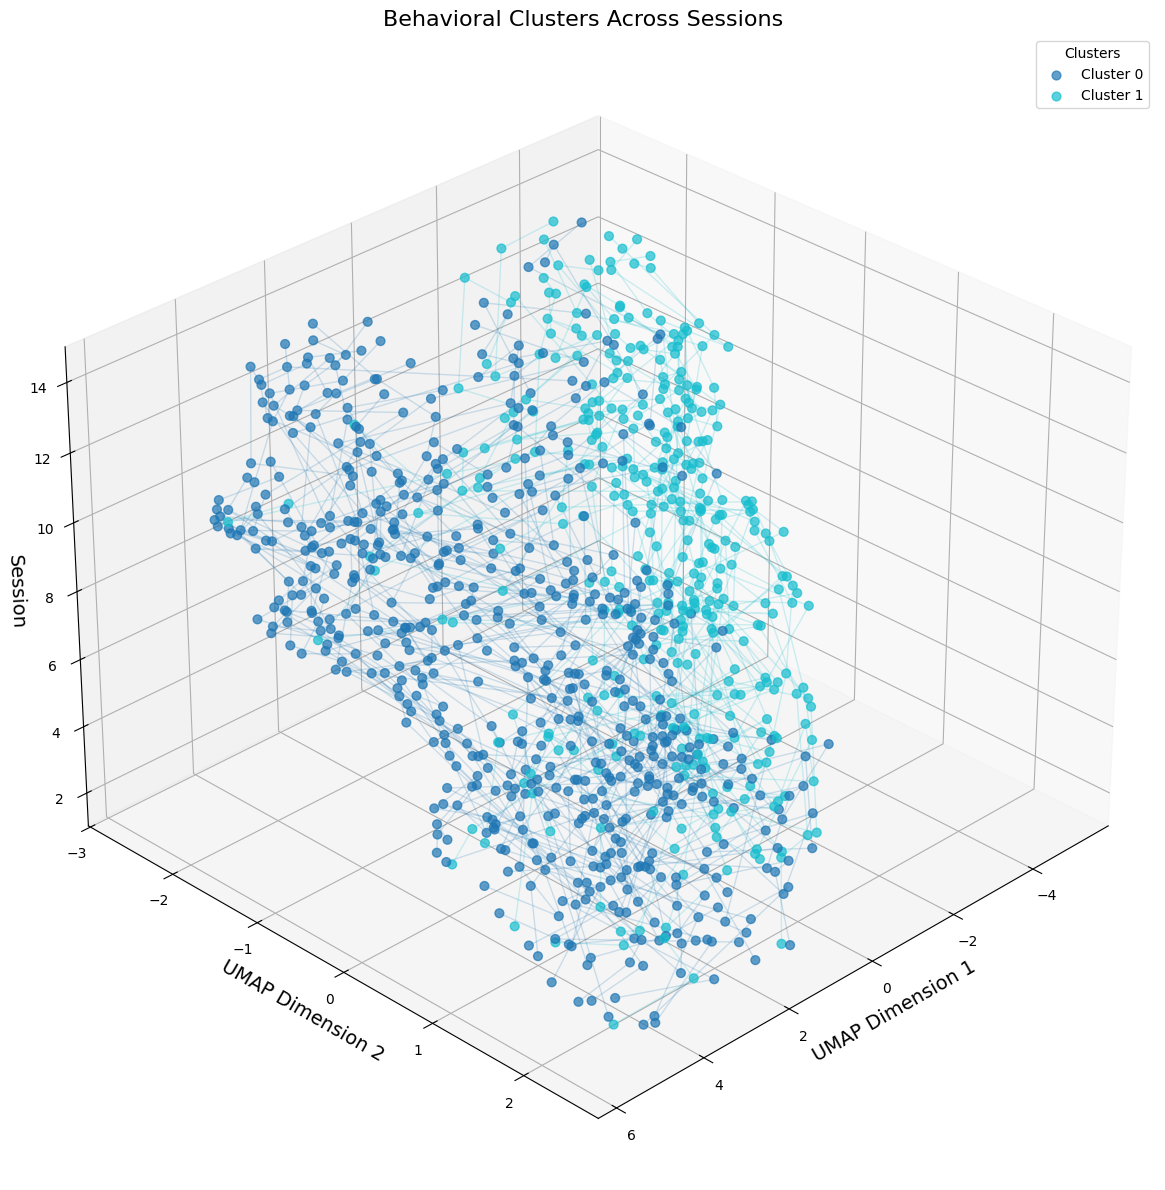

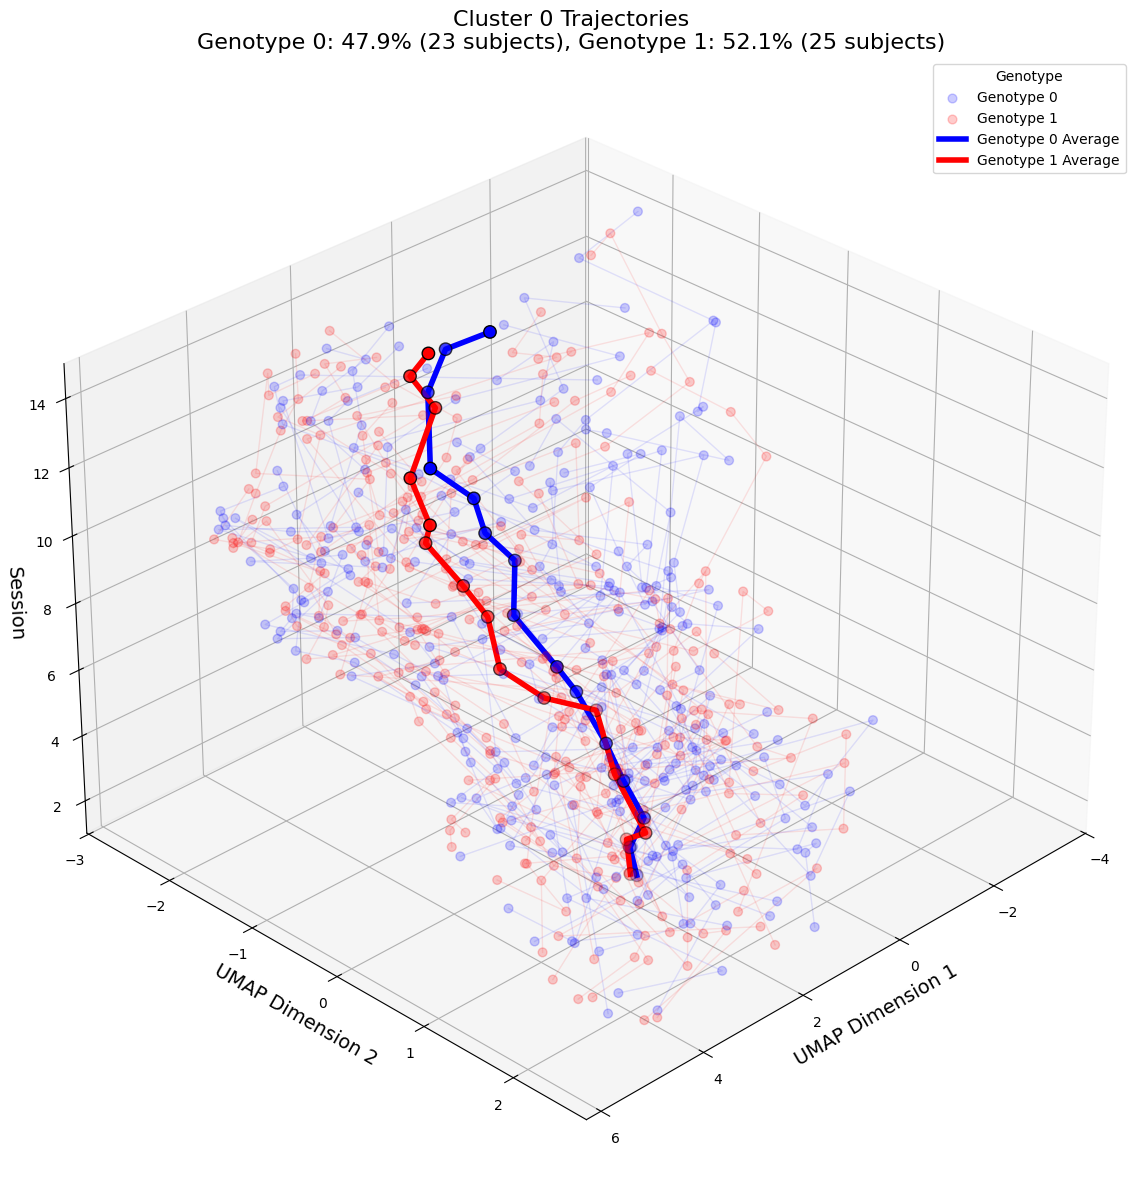

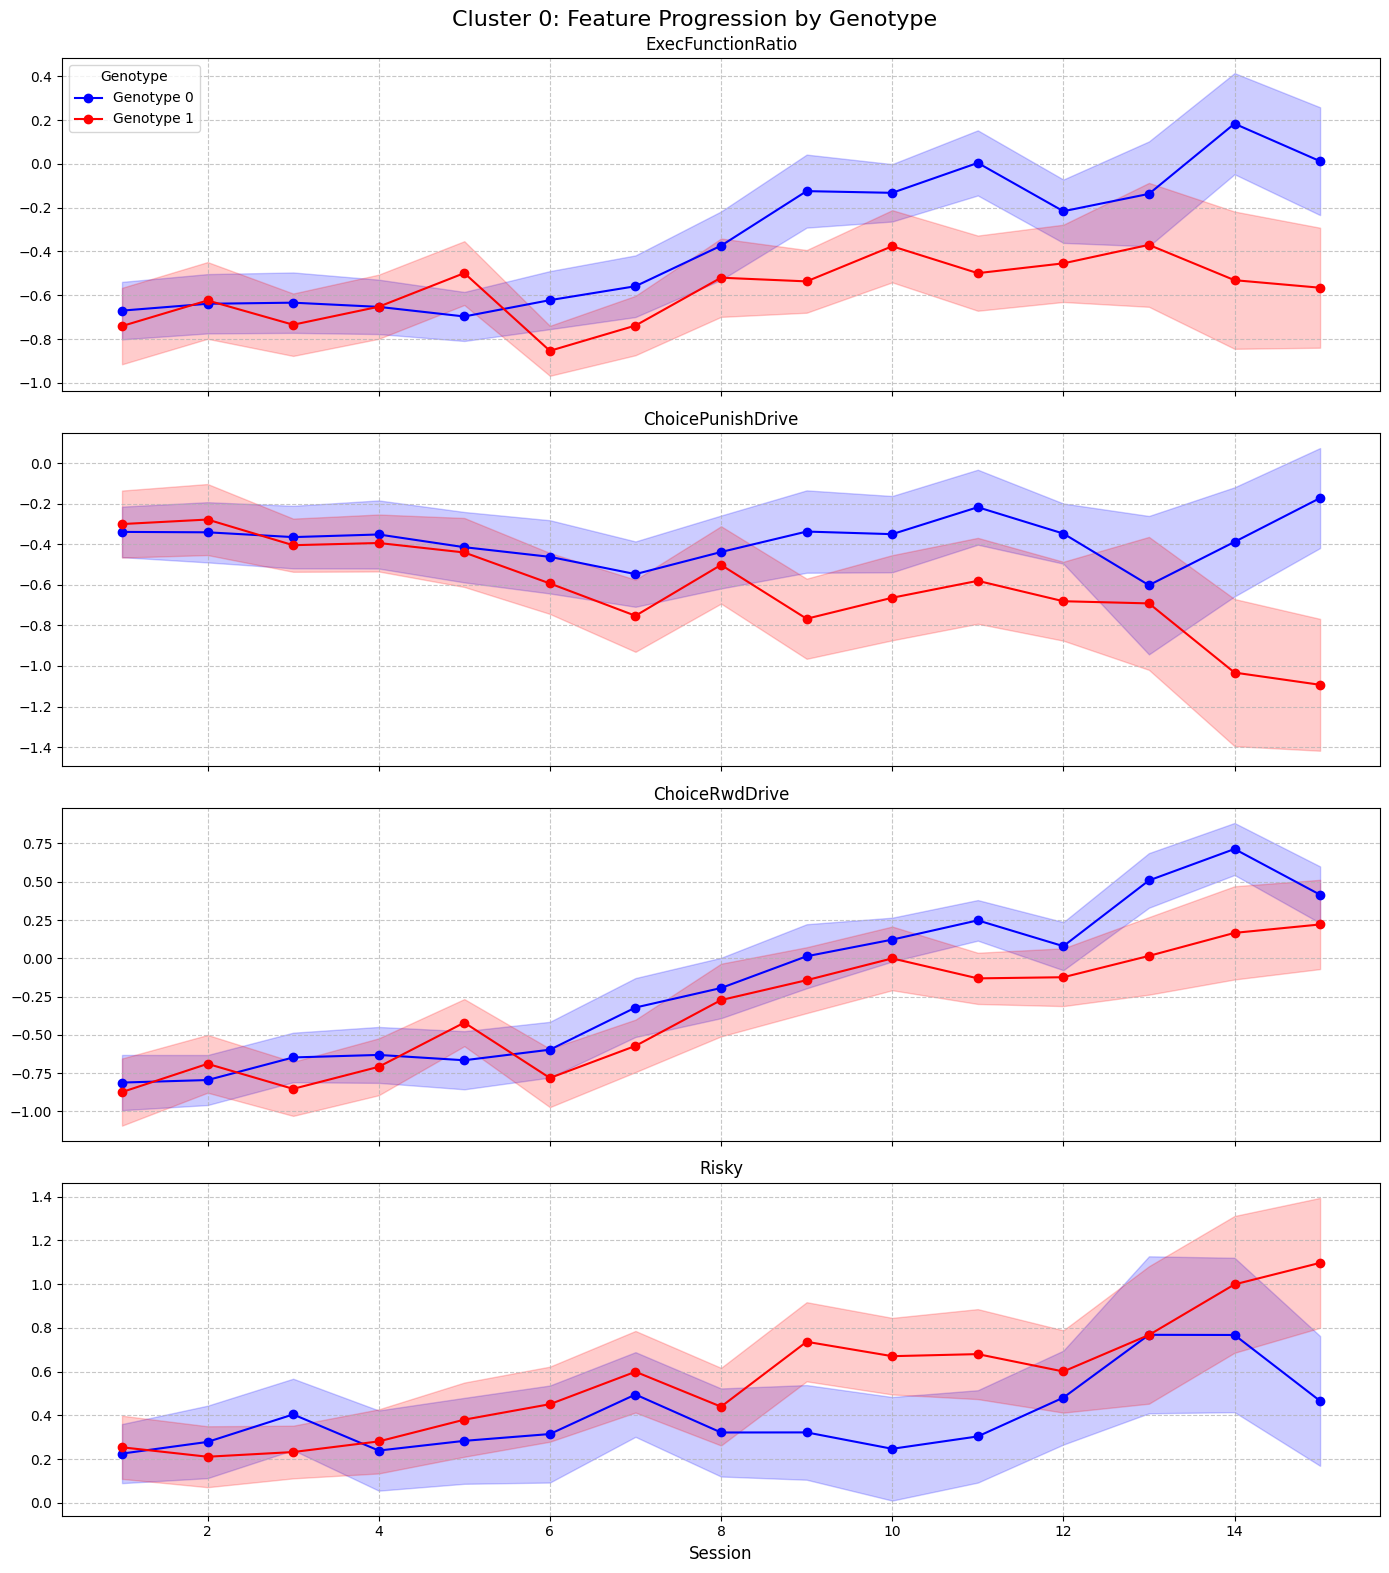

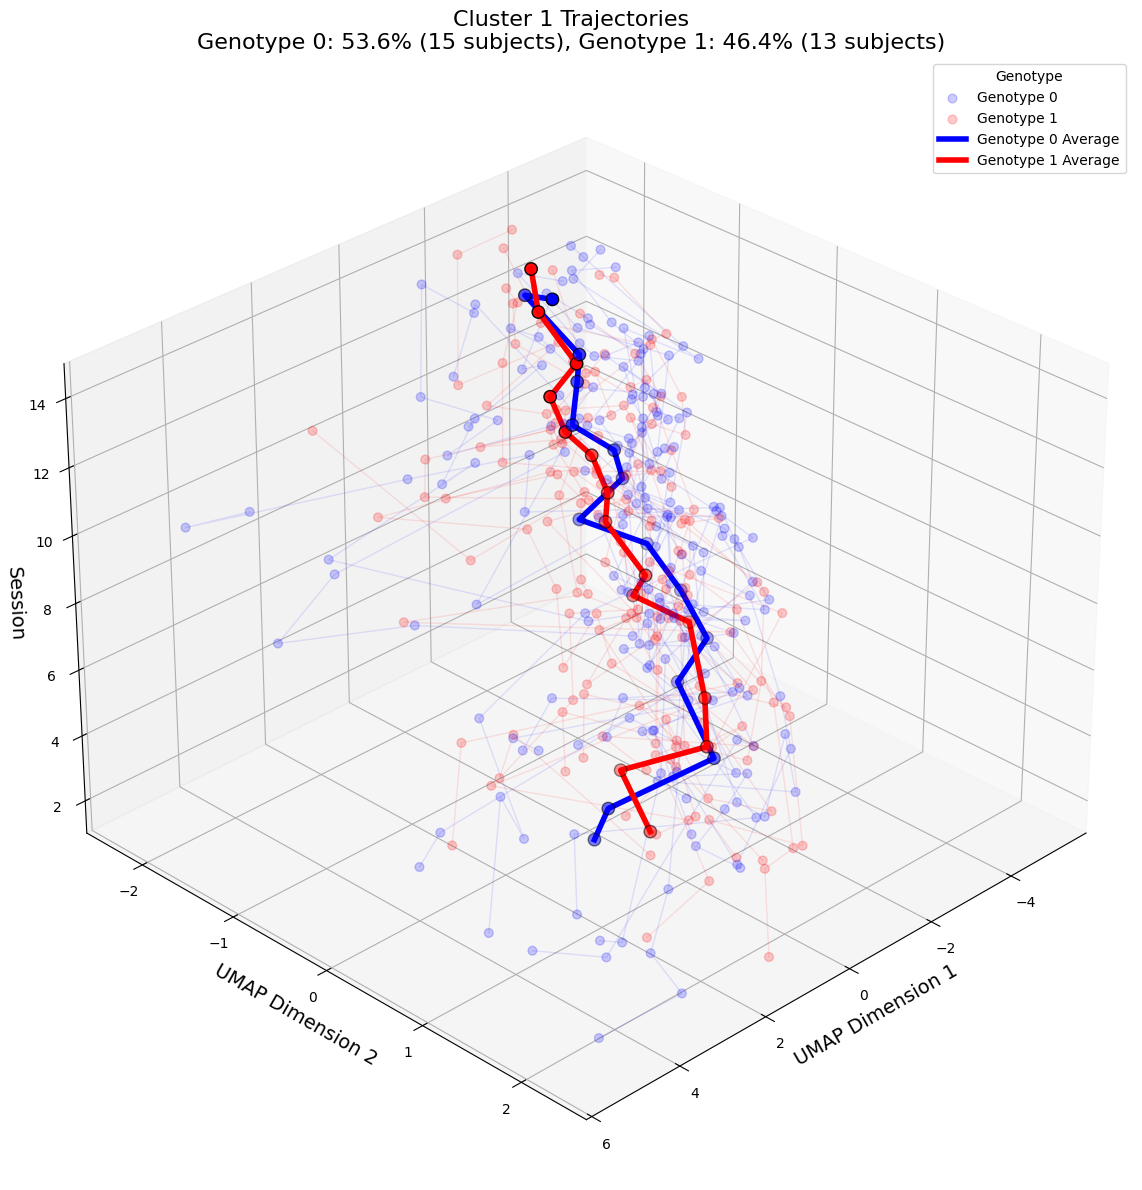

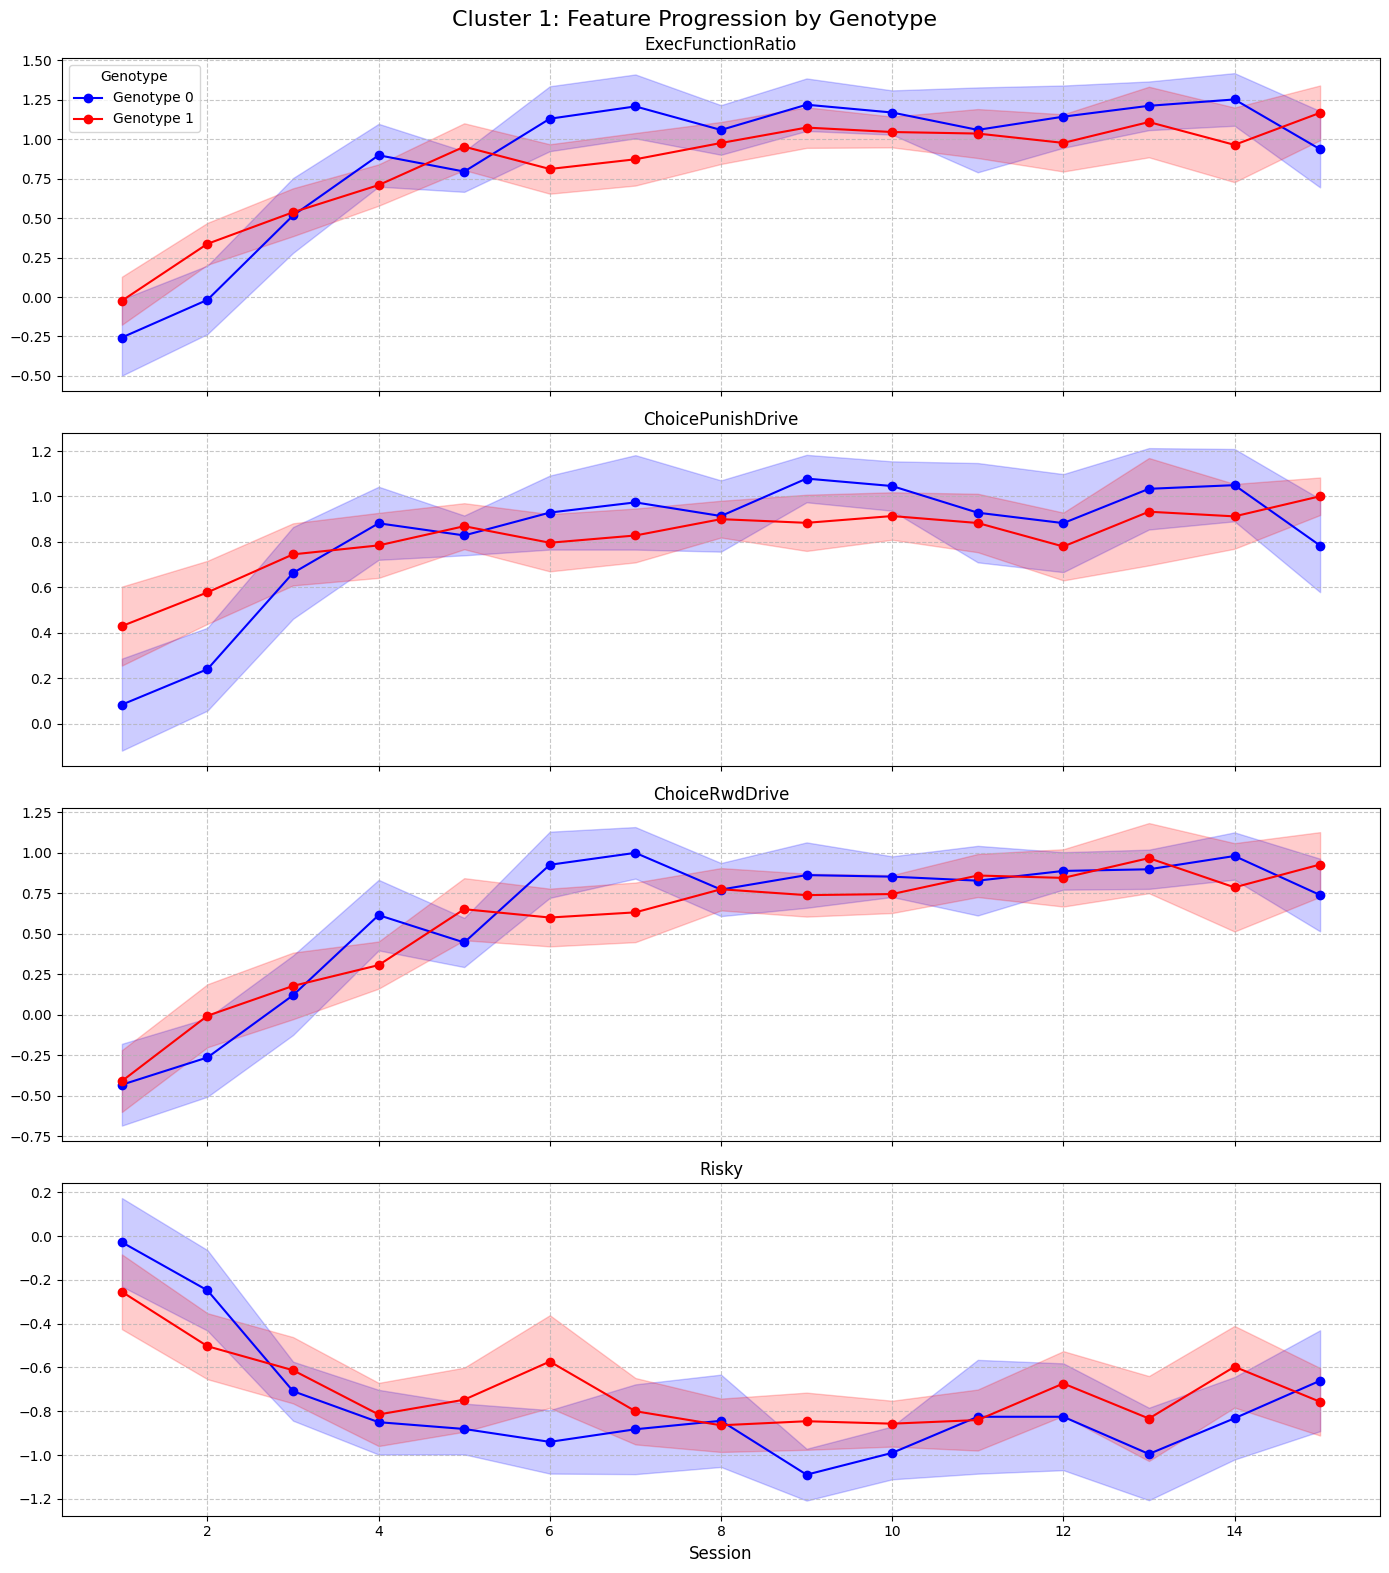

In [25]:
# Combine all embeddings for clustering
all_embeddings = np.vstack([embedding for embedding in embeddings])
all_subjects = np.concatenate([subjects for subjects in session_subjects])
all_genotypes = np.concatenate([genotypes for genotypes in session_genotypes])
all_sessions = np.concatenate([[i+1]*len(subjects) for i, subjects in enumerate(session_subjects)])

# Perform KMeans clustering
n_clusters = 2  # Adjust based on your data
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(all_embeddings)

# Assign each subject to its predominant cluster
subject_clusters = {}
for subject in df['Subject'].unique():
    indices = np.where(all_subjects == subject)[0]
    if len(indices) > 0:
        # Get the most common cluster assignment for this subject
        subject_clusters[subject] = np.bincount(cluster_labels[indices]).argmax()

# Add cluster information to the dataframe
df['Cluster'] = df['Subject'].map(subject_clusters)

# Create a figure showing all clusters
fig = plt.figure(figsize=(15, 12))
ax = fig.add_subplot(111, projection='3d')

# Use a distinct colormap for clusters
cluster_colors = plt.cm.tab10(np.linspace(0, 1, n_clusters))

# Plot points colored by cluster
for session_idx, session in enumerate(sessions):
    for cluster in range(n_clusters):
        # Find subjects in this cluster for this session
        cluster_subjects = [s for s, c in subject_clusters.items() if c == cluster]
        indices = [i for i, s in enumerate(session_subjects[session_idx]) 
                  if s in cluster_subjects]
        
        if indices:
            ax.scatter(
                embeddings[session_idx][indices, 0],
                embeddings[session_idx][indices, 1],
                np.ones(len(indices)) * session,
                color=cluster_colors[cluster],
                s=40,
                alpha=0.7,
                label=f"Cluster {cluster}" if session_idx == 0 else None
            )

# Plot trajectories colored by cluster
for subject in subjects:
    subject_sessions = sorted(df[df['Subject'] == subject]['Session'].unique())
    if len(subject_sessions) < 2 or subject not in subject_clusters:
        continue
    
    cluster = subject_clusters[subject]
    coords = []
    
    for session in subject_sessions:
        if (subject, session) in subject_to_embedding:
            session_idx, subject_idx = subject_to_embedding[(subject, session)]
            coords.append((
                embeddings[session_idx][subject_idx, 0],
                embeddings[session_idx][subject_idx, 1],
                session
            ))
    
    if len(coords) >= 2:
        coords = np.array(coords)
        ax.plot(coords[:, 0], coords[:, 1], coords[:, 2], 
                color=to_rgba(cluster_colors[cluster], alpha=0.2), 
                linewidth=1.0)

ax.set_title('Behavioral Clusters Across Sessions', fontsize=16)
ax.set_xlabel('UMAP Dimension 1', fontsize=14)
ax.set_ylabel('UMAP Dimension 2', fontsize=14)
ax.set_zlabel('Session', fontsize=14)
ax.set_zlim(1, 15)
ax.legend(title="Clusters")
ax.view_init(elev=30, azim=45)

plt.tight_layout()
plt.show()

# Create separate AlignedUMAP plots for each cluster
for cluster in range(n_clusters):
    # Create figure for this cluster
    fig = plt.figure(figsize=(15, 12))
    ax = fig.add_subplot(111, projection='3d')
    
    # Get subjects in this cluster
    cluster_subjects = [s for s, c in subject_clusters.items() if c == cluster]
    
    # Plot points by genotype within this cluster
    for session_idx, session in enumerate(sessions):
        for genotype in [0, 1]:
            # Find subjects with this genotype in this cluster
            indices = [i for i, (s, g) in enumerate(zip(session_subjects[session_idx], 
                                                        session_genotypes[session_idx])) 
                      if s in cluster_subjects and g == genotype]
            
            if indices:
                ax.scatter(
                    embeddings[session_idx][indices, 0],
                    embeddings[session_idx][indices, 1],
                    np.ones(len(indices)) * session,
                    color=genotype_colors[genotype],
                    s=40,
                    alpha=0.2,
                    label=f"Genotype {genotype}" if session_idx == 0 else None
                )
    
    # Plot trajectories for this cluster
    for subject in cluster_subjects:
        subject_sessions = sorted(df[df['Subject'] == subject]['Session'].unique())
        if len(subject_sessions) < 2:
            continue
        
        genotype = df[df['Subject'] == subject]['Genotype'].iloc[0]
        coords = []
        
        for session in subject_sessions:
            if (subject, session) in subject_to_embedding:
                session_idx, subject_idx = subject_to_embedding[(subject, session)]
                coords.append((
                    embeddings[session_idx][subject_idx, 0],
                    embeddings[session_idx][subject_idx, 1],
                    session
                ))
        
        if len(coords) >= 2:
            coords = np.array(coords)
            ax.plot(coords[:, 0], coords[:, 1], coords[:, 2], 
                    color=to_rgba(genotype_colors[genotype], alpha=0.1), 
                    linewidth=1.0)
    
    # Calculate genotype distribution in this cluster
    cluster_df = df[df['Subject'].isin(cluster_subjects)]
    genotype_counts = cluster_df.groupby('Genotype')['Subject'].nunique()
    genotype_percentages = genotype_counts / genotype_counts.sum() * 100
    genotype_info = ", ".join([f"Genotype {g}: {p:.1f}% ({c} subjects)" 
                              for g, c, p in zip(genotype_counts.index, 
                                               genotype_counts.values, 
                                               genotype_percentages.values)])
    
    # Add average trajectories by genotype within cluster
    for genotype in [0, 1]:
        genotype_subjects = [s for s in cluster_subjects 
                            if df[df['Subject'] == s]['Genotype'].iloc[0] == genotype]
        
        if not genotype_subjects:
            continue
            
        avg_coords_by_session = []
        for session_idx, session in enumerate(sessions):
            indices = [i for i, s in enumerate(session_subjects[session_idx]) 
                      if s in genotype_subjects]
            
            if indices:
                avg_coords = np.mean(embeddings[session_idx][indices], axis=0)
                avg_coords_by_session.append((avg_coords[0], avg_coords[1], session))
        
        if avg_coords_by_session:
            avg_trajectory = np.array(avg_coords_by_session)
            
            # Plot average trajectory with thicker line
            ax.plot(avg_trajectory[:, 0], avg_trajectory[:, 1], avg_trajectory[:, 2], 
                    color=genotype_colors[genotype], 
                    linewidth=4.0, 
                    label=f"Genotype {genotype} Average")
            
            # Add markers at each session point
            ax.scatter(avg_trajectory[:, 0], avg_trajectory[:, 1], avg_trajectory[:, 2], 
                      color=genotype_colors[genotype], s=80, 
                      edgecolors='black', linewidths=1)
    
    ax.set_title(f'Cluster {cluster} Trajectories\n{genotype_info}', fontsize=16)
    ax.set_xlabel('UMAP Dimension 1', fontsize=14)
    ax.set_ylabel('UMAP Dimension 2', fontsize=14)
    ax.set_zlabel('Session', fontsize=14)
    ax.set_zlim(1, 15)
    ax.legend(title="Genotype")
    ax.view_init(elev=30, azim=45)
    
    plt.tight_layout()
    plt.show()
    
    # Create feature progression plot for this cluster
    fig, axes = plt.subplots(len(features), 1, figsize=(14, 4*len(features)), sharex=True)
    
    for i, feature in enumerate(features):
        # Calculate feature means by session and genotype for this cluster
        feature_data = cluster_df.groupby(['Session', 'Genotype'])[feature].agg(
            ['mean', 'sem']).reset_index()
        
        for genotype in [0, 1]:
            data = feature_data[feature_data['Genotype'] == genotype]
            if not data.empty:
                axes[i].plot(data['Session'], data['mean'], marker='o', 
                             color=genotype_colors[genotype], label=f"Genotype {genotype}")
                axes[i].fill_between(data['Session'], 
                                   data['mean'] - data['sem'], 
                                   data['mean'] + data['sem'], 
                                   alpha=0.2, color=genotype_colors[genotype])
        
        axes[i].set_title(feature.split('_')[0], fontsize=12)
        axes[i].grid(True, linestyle='--', alpha=0.7)
        if i == 0:
            axes[i].legend(title="Genotype")
        if i == len(features)-1:
            axes[i].set_xlabel('Session', fontsize=12)
    
    plt.suptitle(f'Cluster {cluster}: Feature Progression by Genotype', fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()


Silhouette Score KMeans K value Optimzation for AlignedUMAP Embedding

For n_clusters = 2, silhouette score is 0.621
For n_clusters = 3, silhouette score is 0.531
For n_clusters = 4, silhouette score is 0.487
For n_clusters = 5, silhouette score is 0.391
For n_clusters = 6, silhouette score is 0.362
For n_clusters = 7, silhouette score is 0.321
For n_clusters = 8, silhouette score is 0.338
For n_clusters = 9, silhouette score is 0.336


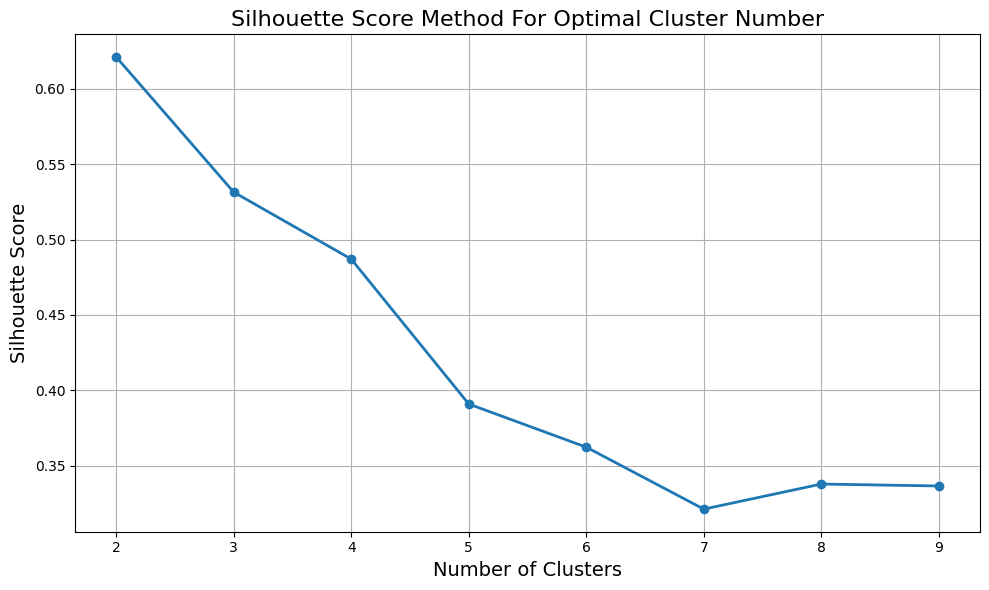

Optimal number of clusters: 2


In [13]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import plotly.graph_objects as go
import plotly.express as px
from scipy import stats

# Extract embeddings for clustering
# Use the final session's embedding for clustering since it represents the endpoint
final_embedding = embeddings[-1]

# Test different numbers of clusters and calculate silhouette scores
silhouette_scores = []
range_n_clusters = range(2, 10)  # Test from 2 to 9 clusters

for n_clusters in range_n_clusters:
    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(final_embedding)
    
    # Calculate silhouette score
    if len(np.unique(cluster_labels)) > 1:  # Ensure at least 2 clusters for silhouette
        score = silhouette_score(final_embedding, cluster_labels)
        silhouette_scores.append(score)
    else:
        silhouette_scores.append(0)
    
    print(f"For n_clusters = {n_clusters}, silhouette score is {silhouette_scores[-1]:.3f}")

# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_scores, 'o-', linewidth=2)
plt.xlabel('Number of Clusters', fontsize=14)
plt.ylabel('Silhouette Score', fontsize=14)
plt.title('Silhouette Score Method For Optimal Cluster Number', fontsize=16)
plt.grid(True)
plt.xticks(range_n_clusters)
plt.tight_layout()
plt.savefig('silhouette_scores.png', dpi=300)
plt.show()

# Get optimal number of clusters
optimal_n_clusters = range_n_clusters[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters: {optimal_n_clusters}")

# Apply optimal clustering
kmeans = KMeans(n_clusters=optimal_n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(final_embedding)

# Store the cluster assignments for each subject in the final session
final_subjects = session_subjects[-1]
subject_to_cluster = {subj: clust for subj, clust in zip(final_subjects, cluster_labels)}

# Backpropagate cluster assignments to earlier sessions
# This ensures we track the same subjects across sessions
all_subject_clusters = []
for session_idx, subjects in enumerate(session_subjects):
    session_clusters = np.full(len(subjects), -1)  # Initialize with -1 (no cluster)
    
    for i, subject in enumerate(subjects):
        if subject in subject_to_cluster:
            session_clusters[i] = subject_to_cluster[subject]
    
    all_subject_clusters.append(session_clusters)


Sub-Cluster Trajectory Comparisons (with and without genotype comparison)

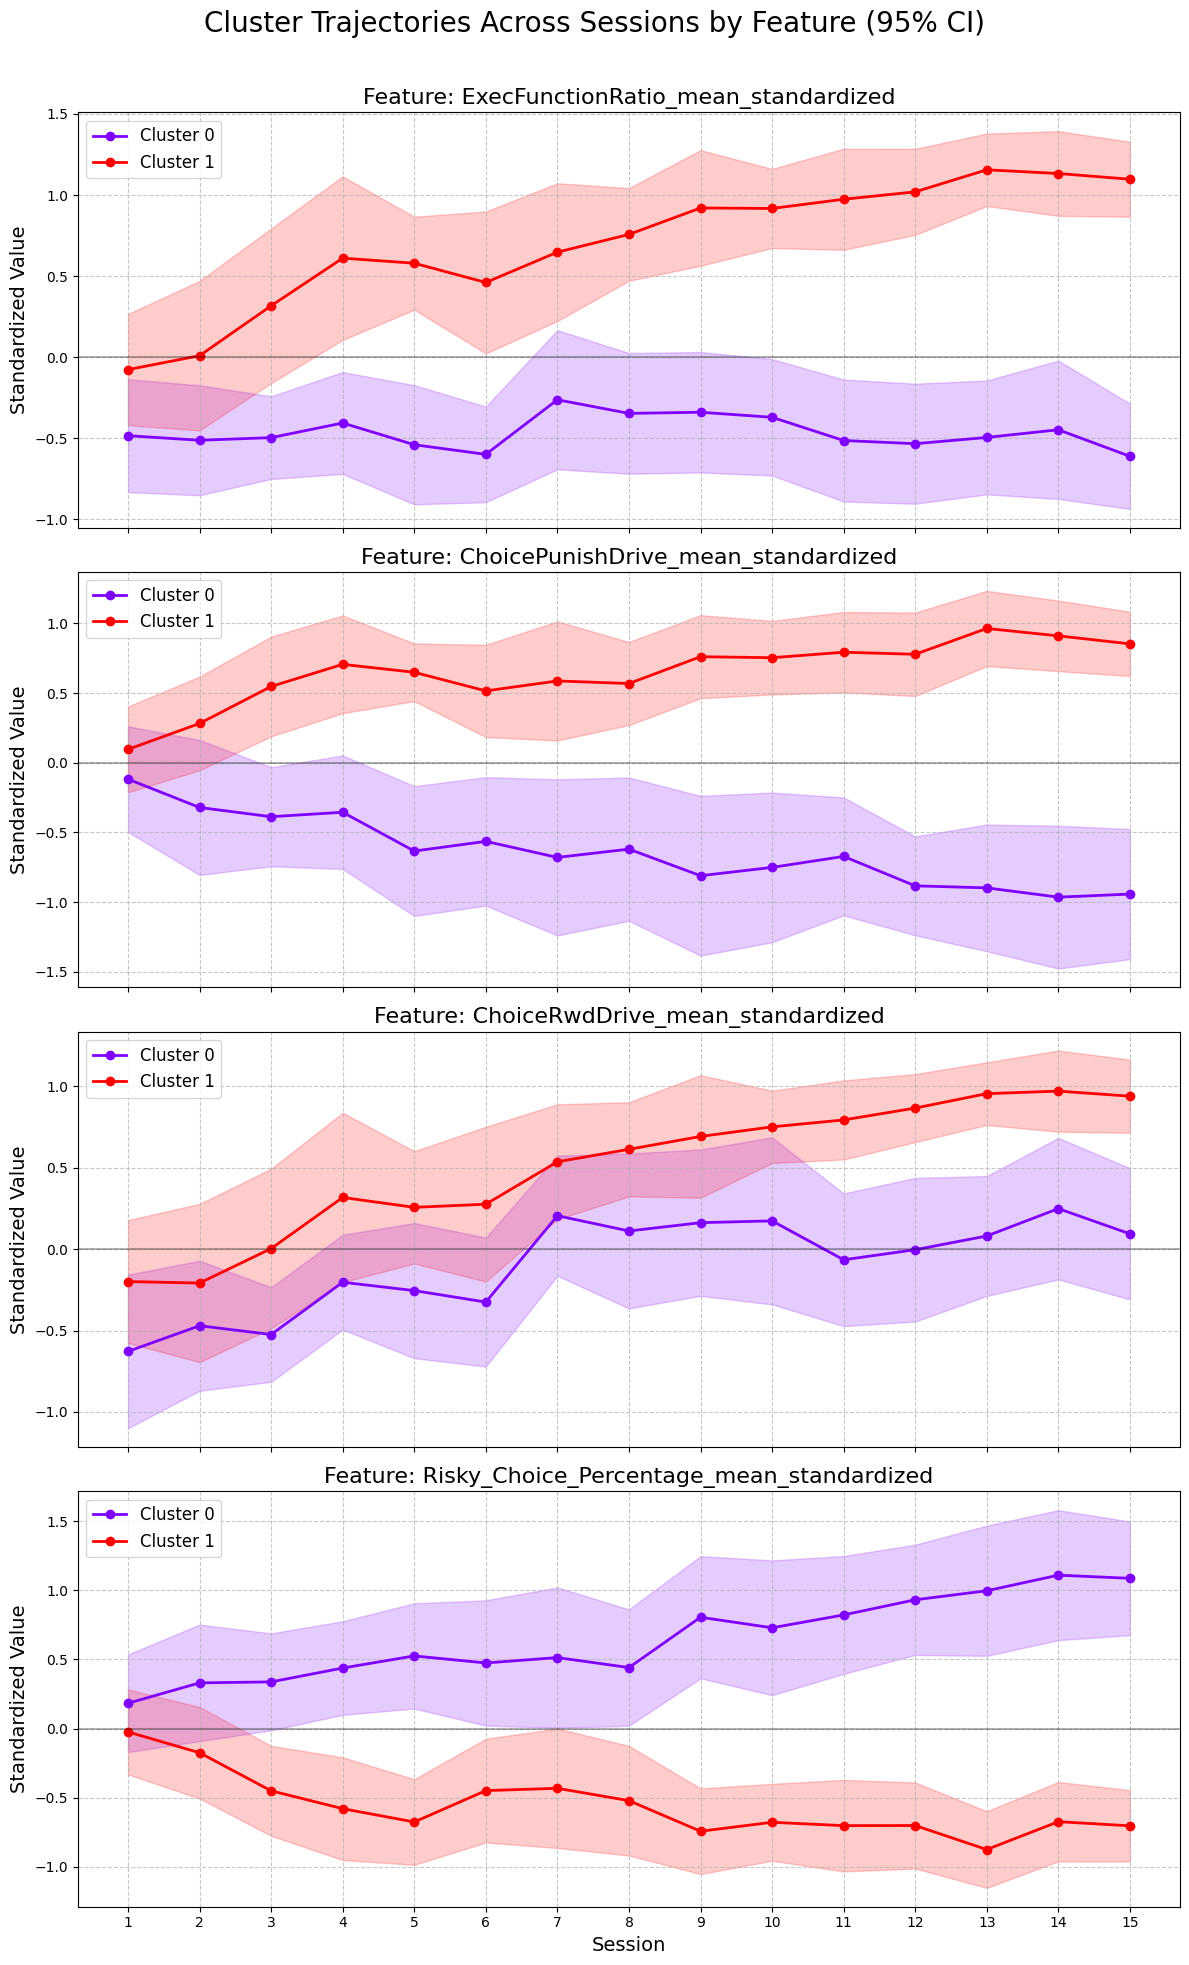

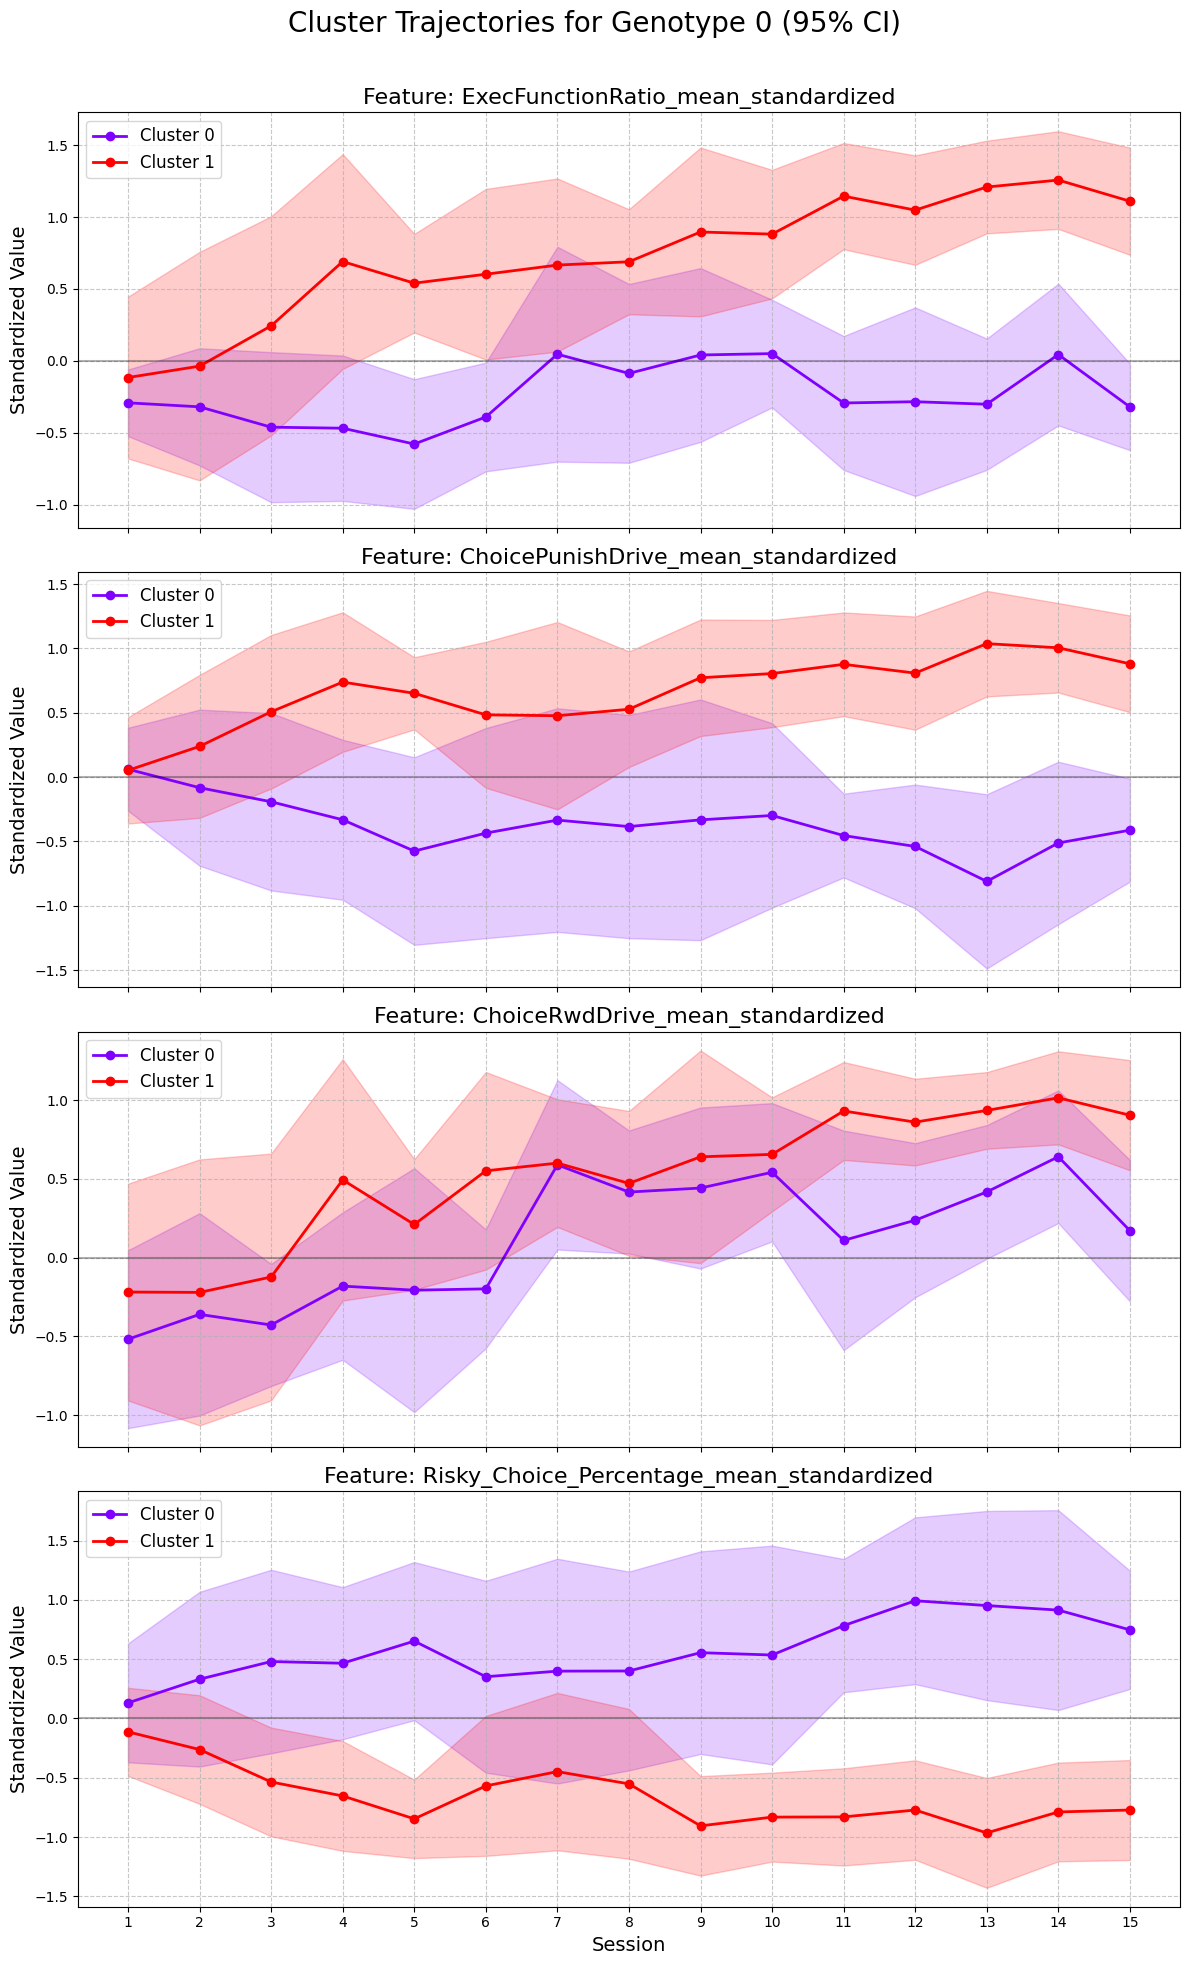

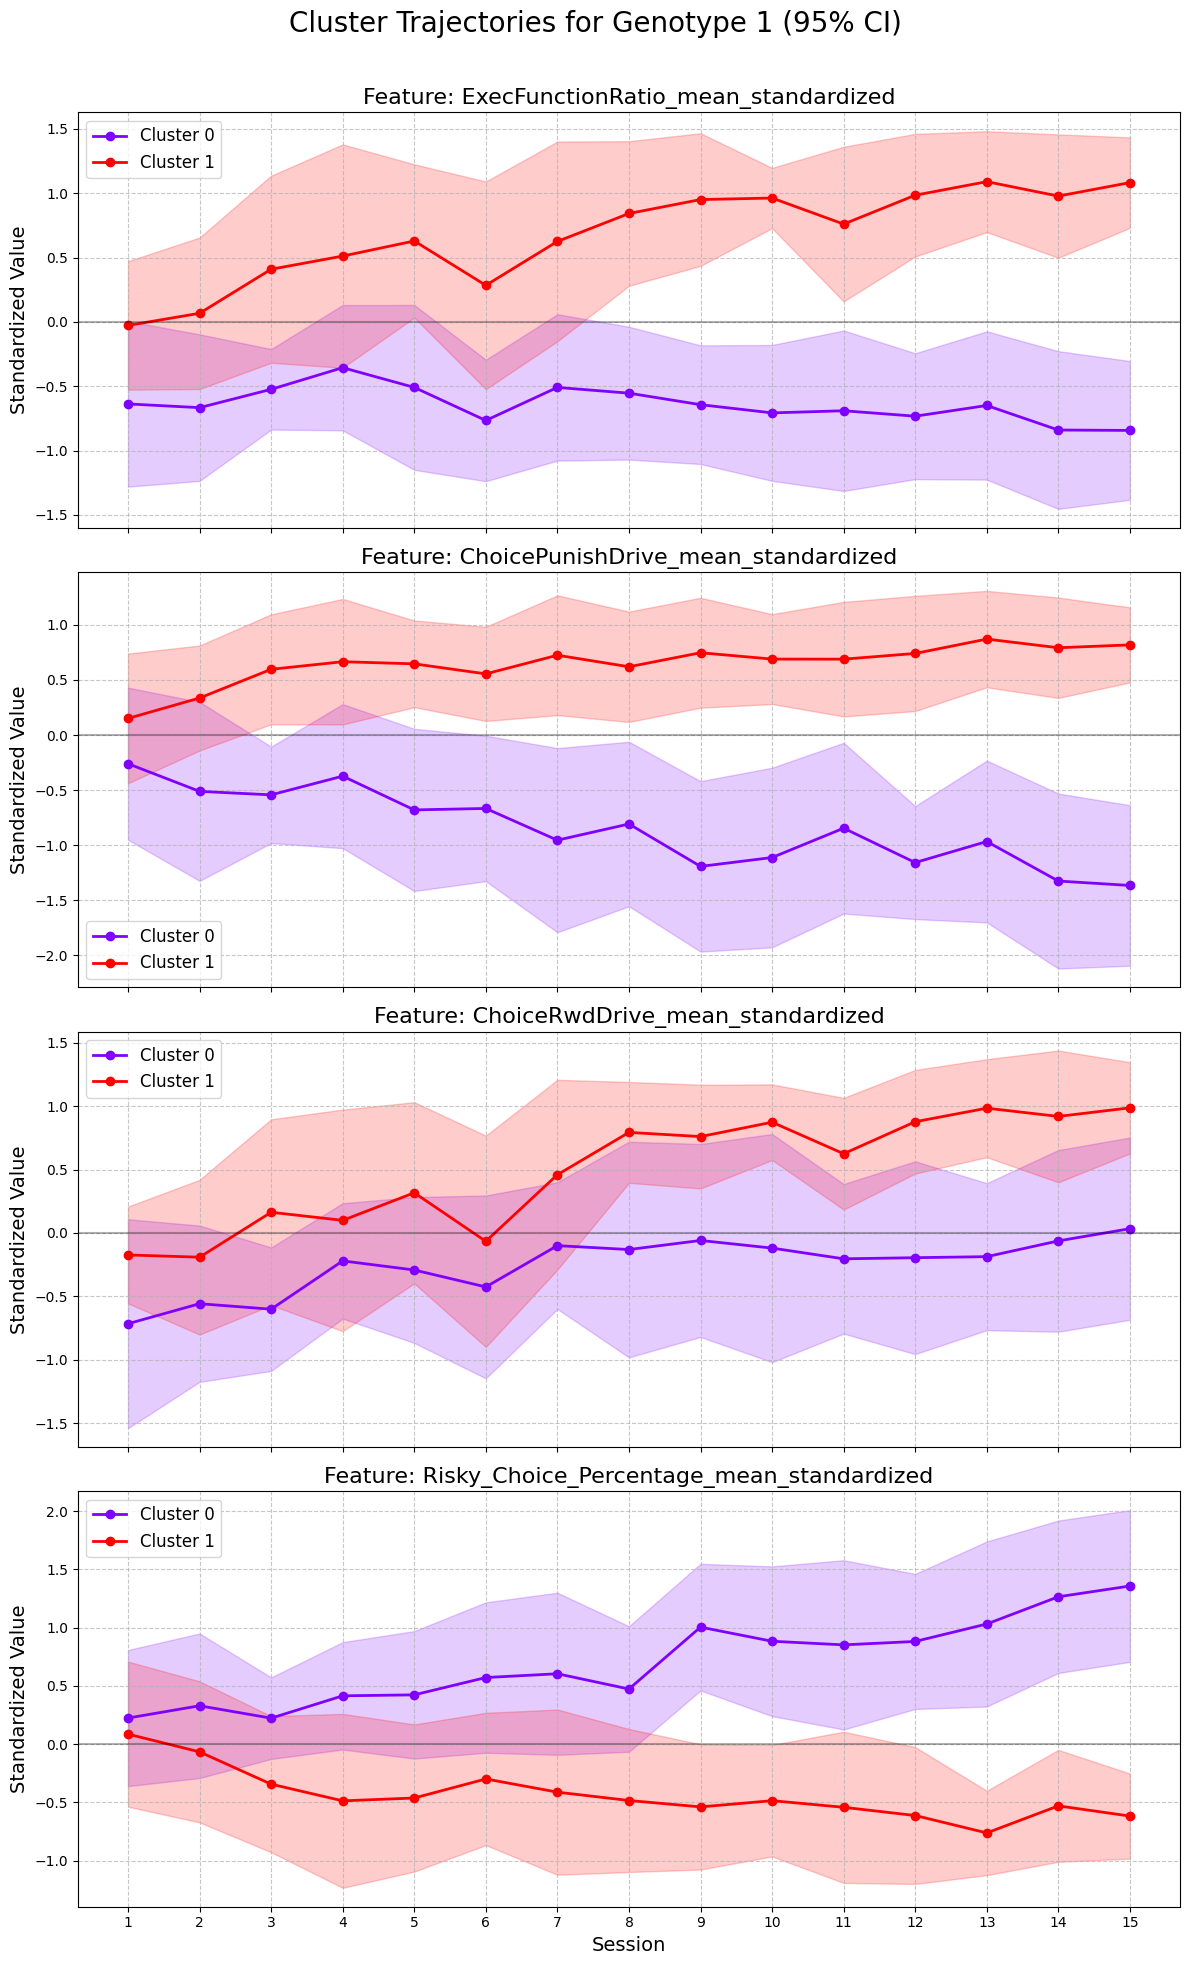

In [24]:
# Features we're tracking
features = [
    'ExecFunctionRatio_mean_standardized',
    'ChoicePunishDrive_mean_standardized',
    'ChoiceRwdDrive_mean_standardized',
    'Risky_Choice_Percentage_mean_standardized'
]

# Create a figure with subplots for each feature
fig, axes = plt.subplots(len(features), 1, figsize=(12, 5*len(features)), sharex=True)
fig.suptitle('Cluster Trajectories Across Sessions by Feature (95% CI)', fontsize=20)

# Get a color map with distinct colors for clusters
colors = cm.rainbow(np.linspace(0, 1, optimal_n_clusters))

# For each feature, plot trajectory of each cluster
for feat_idx, feature in enumerate(features):
    ax = axes[feat_idx]
    
    for cluster_id in range(optimal_n_clusters):
        # Collect feature values across sessions for this cluster
        cluster_values = []
        cluster_ci_lower = []
        cluster_ci_upper = []
        
        for session_idx, session in enumerate(sessions):
            # Get subjects in this cluster for this session
            cluster_mask = all_subject_clusters[session_idx] == cluster_id
            if not np.any(cluster_mask):
                continue
                
            # Get the session data for these subjects
            cluster_subjects = np.array(session_subjects[session_idx])[cluster_mask]
            
            # Extract feature values for these subjects
            feature_vals = []
            for subject in cluster_subjects:
                subject_data = df[(df['Subject'] == subject) & (df['Session'] == session)]
                if not subject_data.empty:
                    feature_vals.append(subject_data[feature].values[0])
            
            if feature_vals:
                # Calculate mean and 95% confidence interval
                mean_val = np.mean(feature_vals)
                if len(feature_vals) > 1:
                    ci = stats.t.interval(0.95, len(feature_vals)-1, loc=mean_val, 
                                          scale=stats.sem(feature_vals))
                    ci_lower = ci[0]
                    ci_upper = ci[1]
                else:
                    # If only one value, can't calculate CI
                    ci_lower = mean_val
                    ci_upper = mean_val
                
                cluster_values.append((session, mean_val))
                cluster_ci_lower.append((session, ci_lower))
                cluster_ci_upper.append((session, ci_upper))
        
        if cluster_values:
            # Convert lists to arrays for plotting
            sessions_array, values_array = zip(*cluster_values)
            _, ci_lower_array = zip(*cluster_ci_lower)
            _, ci_upper_array = zip(*cluster_ci_upper)
            
            # Plot mean line
            ax.plot(sessions_array, values_array, 'o-', color=colors[cluster_id], 
                    linewidth=2, label=f'Cluster {cluster_id}')
            
            # Plot confidence interval
            ax.fill_between(sessions_array, ci_lower_array, ci_upper_array, 
                           color=colors[cluster_id], alpha=0.2)
    
    # Label and format the plot
    ax.set_title(f'Feature: {feature}', fontsize=16)
    ax.set_ylabel('Standardized Value', fontsize=14)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend(fontsize=12)
    
    # Add horizontal line at y=0 for reference
    ax.axhline(y=0, color='k', linestyle='-', alpha=0.3)

# Set x-axis label on the bottom subplot
axes[-1].set_xlabel('Session', fontsize=14)
axes[-1].set_xticks(sessions)
plt.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust for suptitle
plt.savefig('cluster_feature_trajectories.png', dpi=300)
plt.show()

# Now let's split by genotype to compare clusters within each genotype
for genotype in [0, 1]:
    genotype_name = f"Genotype {genotype}"
    
    fig, axes = plt.subplots(len(features), 1, figsize=(12, 5*len(features)), sharex=True)
    fig.suptitle(f'Cluster Trajectories for {genotype_name} (95% CI)', fontsize=20)
    
    for feat_idx, feature in enumerate(features):
        ax = axes[feat_idx]
        
        for cluster_id in range(optimal_n_clusters):
            # Collect feature values across sessions for this cluster and genotype
            cluster_values = []
            cluster_ci_lower = []
            cluster_ci_upper = []
            
            for session_idx, session in enumerate(sessions):
                # Get subjects in this cluster for this session
                cluster_mask = all_subject_clusters[session_idx] == cluster_id
                if not np.any(cluster_mask):
                    continue
                    
                # Get the session data for these subjects
                cluster_subjects = np.array(session_subjects[session_idx])[cluster_mask]
                
                # Extract feature values for these subjects of the current genotype
                feature_vals = []
                for subject in cluster_subjects:
                    subject_data = df[(df['Subject'] == subject) & 
                                      (df['Session'] == session) & 
                                      (df['Genotype'] == genotype)]
                    if not subject_data.empty:
                        feature_vals.append(subject_data[feature].values[0])
                
                if feature_vals:
                    # Calculate mean and 95% confidence interval
                    mean_val = np.mean(feature_vals)
                    if len(feature_vals) > 1:
                        ci = stats.t.interval(0.95, len(feature_vals)-1, loc=mean_val, 
                                              scale=stats.sem(feature_vals))
                        ci_lower = ci[0]
                        ci_upper = ci[1]
                    else:
                        # If only one value, can't calculate CI
                        ci_lower = mean_val
                        ci_upper = mean_val
                    
                    cluster_values.append((session, mean_val))
                    cluster_ci_lower.append((session, ci_lower))
                    cluster_ci_upper.append((session, ci_upper))
            
            if cluster_values:
                # Convert lists to arrays for plotting
                sessions_array, values_array = zip(*cluster_values)
                _, ci_lower_array = zip(*cluster_ci_lower)
                _, ci_upper_array = zip(*cluster_ci_upper)
                
                # Plot mean line
                ax.plot(sessions_array, values_array, 'o-', color=colors[cluster_id], 
                        linewidth=2, label=f'Cluster {cluster_id}')
                
                # Plot confidence interval
                ax.fill_between(sessions_array, ci_lower_array, ci_upper_array, 
                               color=colors[cluster_id], alpha=0.2)
        
        # Label and format the plot
        ax.set_title(f'Feature: {feature}', fontsize=16)
        ax.set_ylabel('Standardized Value', fontsize=14)
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.legend(fontsize=12)
        
        # Add horizontal line at y=0 for reference
        ax.axhline(y=0, color='k', linestyle='-', alpha=0.3)

    # Set x-axis label on the bottom subplot
    axes[-1].set_xlabel('Session', fontsize=14)
    axes[-1].set_xticks(sessions)
    plt.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust for suptitle
    plt.savefig(f'cluster_feature_trajectories_{genotype_name}.png', dpi=300)
    plt.show()


In [29]:
def create_interactive_dashboard_v2():
    # Data preparation with safety checks
    if not hasattr(reducer, 'embeddings_'):
        raise ValueError("AlignedUMAP not fitted - run fit_transform() first")
        
    # Create plotting dataframe
    plot_data = []
    for session_idx, session in enumerate(sessions):
        for subject_idx, subject in enumerate(session_subjects[session_idx]):
            try:
                genotype = session_genotypes[session_idx][subject_idx]
                cluster = all_subject_clusters[session_idx][subject_idx]
            except IndexError:
                continue
                
            plot_data.append({
                'Subject': subject,
                'Session': session,
                'Genotype': genotype,
                'Cluster': cluster,
                'UMAP_1': embeddings[session_idx][subject_idx, 0],
                'UMAP_2': embeddings[session_idx][subject_idx, 1],
                'Z': session
            })
    
    plot_df = pd.DataFrame(plot_data)
    
    # Add feature data through safe merge
    feature_df = df[['Subject', 'Session'] + features].drop_duplicates()
    plot_df = pd.merge(plot_df, feature_df, on=['Subject', 'Session'], how='left')
    
    # Create figure with explicit encoding
    dashboard_fig = px.scatter_3d(
        plot_df,
        x='UMAP_1',
        y='UMAP_2',
        z='Z',
        color='Cluster',
        symbol='Genotype',
        color_discrete_sequence=px.colors.qualitative.Bold,
        symbol_map={0: 'circle', 1: 'diamond'},
        hover_data=['Subject', 'Session', 'Genotype', 'Cluster'] + features,
        title="Interactive 3D AlignedUMAP Analysis Dashboard"
    )
    
    # Add trajectories with session continuity check
    for subject in plot_df['Subject'].unique():
        subject_data = plot_df[plot_df['Subject'] == subject].sort_values('Session')
        if len(subject_data) > 1 and (subject_data['Session'].diff().dropna() == 1).all():
            dashboard_fig.add_trace(
                go.Scatter3d(
                    x=subject_data['UMAP_1'],
                    y=subject_data['UMAP_2'],
                    z=subject_data['Z'],
                    mode='lines',
                    line=dict(width=1, color='rgba(50,50,50,0.2)'),
                    showlegend=False,
                    hoverinfo='skip'
                )
            )
    
    # Layout improvements
    dashboard_fig.update_layout(
        scene=dict(
            xaxis_title='UMAP 1',
            yaxis_title='UMAP 2', 
            zaxis_title='Session',
            zaxis=dict(range=[1, 15], tickvals=list(range(1,16))),
            camera=dict(up=dict(x=0, y=0, z=1))  # Standard orientation
        ),
        legend=dict(
            title='Legend',
            itemsizing='constant',
            itemclick=False,
            itemdoubleclick=False
        ),
        margin=dict(l=0, r=0, b=30, t=50)
    )
    
    return dashboard_fig
